# Star and Planet Formation Summer Internship 🪐🌟

---
### **Daniel Bielech** (db662)
### Supervised by **Dr Dirk Froebrich** and **Dr Stuart Gibson**
#### School of Physics and Astronomy 🔭 - University of Kent
##### 📅 12th June - 31st July 2023
##### 🌐 Information about the HOYS project: https://hoys.space/

This project aims to analyze the variability of young stars. Using data from the Hunting Outbursting Young Stars (HOYS) project, we will employ machine learning techniques to cluster the variability fingerprints of approximately 3000 young stars.

The project will contribute to understanding the relationship between variability behavior and disk structure, with potential implications for star properties and their environment. Findings will be incorporated into publications and work of MSc/PhD students, supporting future research in this field.

The ultimate objective of this project is to obtain variability fingerprint data from realistic disk models and apply the same clustering algorithms to compare the results with real data. This comparative analysis will help determine the validity and realism of the simulations, providing valuable insights into the accuracy of our models.

---

### Visualizing the data

We randomly select a .npy file from the data folder and load its content. The selected data sample is then visualized using an image plot. By examining this random sample, we can gain an initial understanding of the data and its characteristics, which will help inform our subsequent clustering analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.ticker as ticker

# Path to data directory
data_dir = "data"

""" visualise the data sample using a heatmap plot
  Args:
    sample (np.ndarray): data sample
    title (str): title of the plot (if None, no title is added)
"""
def visualise_from_data(sample, title=None, save_path=None):
    # Clear the current figure
    plt.clf()
    # Set up the plot, x-axis, and y-axis bounds are set in the extent argument
    plt.imshow(sample.T, cmap=plt.cm.viridis, aspect='auto', extent=[1, 3, -2, 2.])
    
    # Add labels and a colorbar
    plt.xlabel("$\Delta t$ $(log_{10}(days))$")
    plt.ylabel("$\Delta m$ (mag)")
    plt.colorbar(label='Probability')

    # Set the title of the plot
    if title is not None:
        plt.title(title)

    # Optionally save the plot to a file
    if save_path is not None:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def visualise_from_file(file_name, title=None):
  # Load the data from the file
  sample = np.load(f"{data_dir}/{file_name}")
  # visualise the data sample
  visualise_from_data(sample, title)

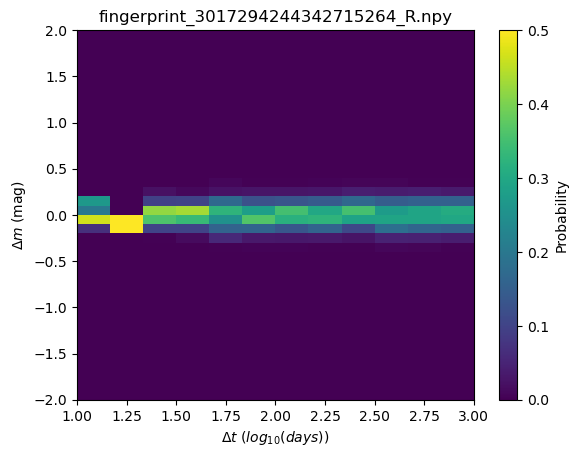

In [2]:
import os

# Get the list of npy file paths in the data directory
file_paths = glob.glob(data_dir + "/*.npy")

file_names = [os.path.basename(path) for path in file_paths]

# Select a random file from the list
random_data_path = np.random.choice(file_names)

visualise_from_file(random_data_path, title=random_data_path)


---

## **Functions**

#### Importing the dataset - pipeline

1. **Load the data**

2. **Preprocess the data**

3. **Store in a NumPy array**

4. **Reduce dimensions** (Optional)

In [3]:
from sklearn.preprocessing import MinMaxScaler

""" Apply the preprocessing steps to the data sample """
def preprocess_data(data, flatten, log_transform, normalize, log_epsilon):
    # Crop the data to remove the first time bins
    data_pre = data[3:, :]
    if normalize:
        # Normalize the data using a scaler
        scaler = MinMaxScaler()
        data_pre = scaler.fit_transform(data_pre)
    if log_transform:
        # Add a constant value to avoid taking the logarithm of zero
        data_pre += log_epsilon
        # Apply the logarithmic operation
        data_pre = np.log10(data_pre)
    if flatten:
        # Flatten the data
        data_pre = data_pre.flatten()
    return data_pre

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.initializers import Constant
from keras.optimizers import Adam
import tensorflow as tf

def reduce_dimensions(data, n_components=2, method="PCA", init="random", learning_rate=0.00001):
    if method == "PCA":
        return reduce_dimensions_PCA(data, n_components)
    elif method == "t-SNE":
        return reduce_dimensions_tSNE(data, init)
    elif method == "autoencoder":
        return reduce_dimensions_autoencoder(data, learning_rate)
    else:
        raise ValueError("Unknown algorithm type: {}".format(method))

def reduce_dimensions_tSNE(data, init):
    # Apply t-SNE
    print("Shape of the data before t-SNE: {}".format(data.shape))
    tsne = TSNE(n_components=2, learning_rate='auto', init=init)
    embedded_data = tsne.fit_transform(data)
    print("Shape of the data after t-SNE: {}".format(embedded_data.shape))
    return embedded_data

def reduce_dimensions_PCA(data, n_components):
    # Apply PCA
    print("Shape of the data before PCA: {}".format(data.shape))
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    print("Shape of the data after PCA: {}".format(reduced_data.shape))
    return reduced_data

def reduce_dimensions_autoencoder(data, learning_rate):
    # Apply autoencoder
    print("Shape of the data before autoencoder: {}".format(data.shape))
    # Defining the autoencoder model
    input_dim = data.shape[1]
    autoencoder, encoder, decoder = get_autoencoder_model(input_dim, learning_rate)

    # Projecting the data onto the lower-dimensional latent space
    reduced_data = get_reduced_data(autoencoder, encoder, data)

    # Repeat until both dimensions are not all zeros 
    # This is to avoid the case where the autoencoder reduces the data to all zeros
    # This is due to the fact that the autoencoder initial weights are random 
    while (np.sum(reduced_data[:, 0] == 0) > len(reduced_data)/2) or (np.sum(reduced_data[:, 1] == 0) > len(reduced_data)/2):
        autoencoder, encoder, decoder = get_autoencoder_model(input_dim, learning_rate)
        reduced_data = get_reduced_data(autoencoder, encoder, data)

    print("Shape of the data after autoencoder: {}".format(reduced_data.shape))
    return reduced_data

def get_autoencoder_model(input_dim, learning_rate):
    encoding_dim = 2
      # Defining the encoder part of the network
    encoder = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(encoding_dim, activation='relu')
    ])
    # Defining the decoder part of the network
    decoder = Sequential([
        Dense(64, activation='relu', input_shape=(encoding_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(input_dim, activation='linear')
    ])

    autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mse')

    return autoencoder, encoder, decoder

def get_reduced_data(autoencoder, encoder, data):
    # Training the model
    autoencoder.fit(data, data, epochs=30, batch_size=64, verbose=0)

    # Projecting the data onto the lower-dimensional latent space
    reduced_data = encoder(data)

    return reduced_data


In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

""" Load and preprocess the data samples 
    Args:
        folder_path (str): path to the folder containing the data samples
        filter_type (str): filter type (e.g., "V", "R", "I")
        flatten (bool): whether to flatten the data samples
        log_transform (bool): whether to apply a logarithmic transformation to the data samples
        normalize (bool): whether to normalize the data samples
        log_epsilon (float): constant value to add to the data samples before applying the logarithmic transformation
"""
def load_data_samples(folder_path, filter_type="I", flatten=False, log_transform=False, normalize=False, log_epsilon=10e-8):
    files = glob.glob(folder_path + "/*.npy")
     # Only get files for specified filter type
    if filter_type is not None:
        files = [path for path in files if filter_type in path]
    print("Number of data samples: {}".format(len(files)))
    # Initialize an empty list to store data samples
    data_samples = []
    # Initialize an empty list to store file names
    file_names = []
    # Load and process each npy file
    for f in files:
        # Load the npy file
        data = np.load(f)
        
        # Perform any preprocessing steps
        preprocessed_data = preprocess_data(data, flatten=flatten, log_transform=log_transform, normalize=normalize, log_epsilon=log_epsilon)

        # Append the preprocessed data to the list of data samples
        data_samples.append(preprocessed_data)

        # Append the file name to the list file names
        file_names.append(os.path.split(f)[1])

    data_samples_array = np.array(data_samples)
    file_names = np.array(file_names)

    print("The shape of the data: {}".format(data_samples_array.shape))
    return data_samples_array, file_names

In [6]:

""" Load a single data sample 
    Args:
        data_dir (str): path to the data directory
        file_name (str): name of the file containing the data sample
"""
def load_sample(file_name, data_dir):
    file_path = os.path.join(data_dir, file_name)
    return np.load(file_path)

In [7]:
import os

def create_data_folder(data_folder):
    """
    Ensure that a data folder exists. If it doesn't exist, create it.
    
    Parameters:
    - data_folder (str): The path to the data folder
    """
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

#### K-means algorthim

In [8]:
from sklearn.cluster import KMeans

def perform_kmeans_clustering(data_samples_reduced, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters).fit(data_samples_reduced)
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    return cluster_labels, cluster_centers

#### Finding optimal value of k clusters using Elbow Method and Silhouette Coefficient Method

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_optimal_k(data_samples_reduced, k_min=2, k_max=11):
    k_values = range(k_min, k_max)
    inertia_values = []
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data_samples_reduced)
        inertia_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data_samples_reduced, kmeans.labels_))

    # Plot the elbow curve and silhouette scores
    plt.figure()
    plt.plot(k_values, inertia_values, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    plt.figure()
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores')

    plt.show()

#### Cumulative explained variance ratio analysis for PCA

In [10]:
from sklearn.decomposition import PCA

def find_optimal_no_components(data_samples, threshold=0.90):
  """
  Find the optimal number of components to capture a certain percentage of the variance
  Args:
    data_samples (numpy array): array of data samples
    threshold (float): threshold for capturing the variance
  """

  pca = PCA()
  pca.fit(data_samples)

  # Calculate the cumulative sum of the explained variance ratio
  cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

  optimal_n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1
  print("Number of components capturing {}% of the variance: {}".format(threshold * 100, optimal_n_components))

  # Plot the cumulative explained variance ratio vs. the number of components
  plt.figure()
  plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio)
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Cumulative Explained Variance Ratio')
  plt.grid()
  plt.show()

  return optimal_n_components

#### Vizualising the reduced data

In [22]:
import matplotlib.pyplot as plt

def plot_reduced_data(x_reduced, y_reduced, method="", color=None, color_label=None, save_path=None):
    plt.clf()
    if color is not None:
        plt.scatter(x_reduced, y_reduced, c=color)
        cbar = plt.colorbar()
        if color_label is not None:
            cbar.set_label(color_label)
    else:
        plt.scatter(x_reduced, y_reduced)
    plt.title("Data reduced using {}".format(method))
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    # Optionally save the plot to a file
    if save_path is not None:
        create_data_folder(os.path.split(save_path)[0])
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

#### Calculating the number of 0s in each data samples

In [12]:
import numpy as np

def count_zeros(data, zero_value):
    """ 
    Count the number of zeros in each data sample
    Args:
        data (numpy array): array of data samples
        zero_value (int): value of the zero
    """
    n_zeros = np.sum(data == zero_value, axis=1)
    return n_zeros

#### Vizualising the clusters

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_k_means_clusters(data_samples_reduced, cluster_labels, cluster_centers, title="K-means Clustering", save_path=None):
    plt.clf()
    # Create a color map
    colormap = plt.cm.get_cmap('viridis', len(np.unique(cluster_labels)))
    colors = colormap(np.arange(len(np.unique(cluster_labels))))

    # Plot the data points and their corresponding cluster assignments
    for i, label in enumerate(np.unique(cluster_labels)):
        plt.scatter(data_samples_reduced[cluster_labels == label, 0],
                    data_samples_reduced[cluster_labels == label, 1],
                    label=f"Cluster {i}", marker='o', alpha=0.5, s=60, color=colors[i])

    # Plot the centroids
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=100, label='Centroids')

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.title(title)
    # Optionally save the plot to a file
    if save_path is not None:
        create_data_folder(os.path.split(save_path)[0])
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

#### Analysing the clusters

In [14]:
import numpy as np
import random

def analyze_clusters(file_names, data_samples, cluster_labels, n_clusters, n_samples=1, visualise_mean_variance=False):
    for cluster_id in range(n_clusters):
        print(f"Cluster {cluster_id}:")

        # Get the indices of the samples in the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]

        # Get the samples in the current cluster
        cluster_samples = [data_samples[idx] for idx in cluster_indices]

       # Load the raw samples for the current cluster
        cluster_samples_raw = [load_sample(file_names[idx], data_dir) for idx in cluster_indices]
        # Calculate the mean of the raw samples
        cluster_mean_raw = np.mean(cluster_samples_raw, axis=0)
        # Calculate the variance of the raw samples
        cluster_variance_raw = np.var(cluster_samples_raw, axis=0)

        # Print the cluster statistics
        print(f" Size: {len(cluster_samples)}")
        # Optionally, visualise the mean and variance
        if visualise_mean_variance:
            visualise_from_data(cluster_mean_raw, "Mean")
            visualise_from_data(cluster_variance_raw, "Variance")

        # Select n_samples random indices from the current cluster
        if n_samples > 0:
            random_indices = random.sample(list(cluster_indices), n_samples)

            # visualise the random samples
            for idx in random_indices:
                visualise_from_file(file_names[idx])

        print()

#### DBSCAN

In [15]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def apply_dbscan(data_samples, eps_value=0.5, min_samples=5):
    """
    Apply DBSCAN clustering on histogram data.

    Parameters:
    - data_samples (numpy.ndarray): A data array
    - eps_value (float, optional): The maximum distance between two samples for them to be 
                                    considered as in the same neighborhood. Default is 0.5.
    - min_samples (int, optional): The number of samples in a neighborhood for a point to be 
                                    considered as a core point. Default is 5.

    Returns:
    - cluster_labels (numpy.ndarray): An array of cluster labels for each data point.
    - n_clusters (int): The number of clusters.
    - n_noise (int): The number of noise points.
    """

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
    dbscan.fit(data_samples)

    # Get cluster labels
    cluster_labels = dbscan.labels_

    # Analyze the results
    unique_labels = np.unique(cluster_labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    return cluster_labels, n_clusters, n_noise

#### Visualise DBSCAN clusters

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dbscan_clusters(data_samples_reduced, cluster_labels, n_noise, eps_value, min_samples, title='DBSCAN Clustering'):
    """
    visualise the clusters obtained from DBSCAN clustering algorithm.

    Arguments:
    data_samples_reduced -- numpy array of shape (n_samples, 2) containing the reduced data samples in 2D space.
    cluster_labels -- numpy array of shape (n_samples,) containing the cluster label for each data sample.
    n_noise -- number of noise points in the clustering result.
    eps_value -- the maximum distance between two samples for them to be considered as in the same neighborhood.
    min_samples -- the number of samples in a neighborhood for a point to be considered as a core point.

    """
    print(f'Number of noise points: {n_noise}')

    # visualise the clusters
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    # Custom names for the legend
    cluster_names = ['Noise'] + [f'Cluster {i}' for i in range(len(unique_labels) - 1)]

    for label, col in zip(unique_labels, colors):
        if label == -1:
            # Noise points are colored black
            col = np.array([[0, 0, 0, 1]])  # RGBA for black color
        else:
            col = col[np.newaxis, :]

        class_member_mask = (cluster_labels == label)
        xy = data_samples_reduced[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], color=col)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(cluster_names)
    plt.title(title + f' (eps={eps_value}, min_samples={min_samples})')
    plt.show()

#### Functions for evaluating and saving the clustering results

In [17]:
import numpy as np

def evaluate_clusters_and_save_results(raw_data, file_names,cluster_labels, data_folder, n_samples=0):
  """
  Step 1 - size of each cluster
  - Calculate the size of each cluster
  - Save sizes to a txt file
  Step 2 - mean and variance of each cluster
  - Calculate the mean and variance of each cluster
  - Plot mean nad variance and save as pngs
  Step 3 - representative samples of each cluster
  - Find the representative samples of each cluster
  - Plot representative samples and save as pngs
  """
  # Ensure the data folder exists
  create_data_folder(data_folder)
  unique_labels, cluster_sizes = np.unique(cluster_labels, return_counts=True)

  # Step 1
  save_cluster_sizes(data_folder, unique_labels, cluster_sizes)
      
  # Step 2
  for label in unique_labels:
    # Get indices of data points in current cluster
    indices = np.where(cluster_labels == label)[0]
    # Compute mean and variance for current cluster
    cluster_data = raw_data[indices,:]
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_variance = np.var(cluster_data, axis=0)
    # Plot and save mean and variance
    path = f'{data_folder}/cluster_{label}'
    create_data_folder(path)
    visualise_from_data(cluster_mean, title=f'Cluster {label} - Mean', save_path=f'{path}/mean.png')
    visualise_from_data(cluster_variance, title=f'Cluster {label} - Variance', save_path=f'{path}/variance.png')

  # Step 3
  if n_samples == 0:
    return
  for label in unique_labels:
    # Get indices of data points in current cluster
    indices = np.where(cluster_labels == label)[0]
    # Compute representative samples for current cluster
    cluster_data = raw_data[indices,:]
    cluster_file_names = file_names[indices]
    representative_samples, samples_file_names = get_representative_samples(cluster_data, cluster_file_names, n_samples=n_samples)
    # Plot and save representative samples
    path = f'{data_folder}/cluster_{label}'
    for i in range(n_samples):
      visualise_from_data(representative_samples[i,:], title=f'Cluster {label} - {samples_file_names[i]}', save_path=f'{path}/sample_{i}.png')


def save_cluster_sizes(data_folder, unique_labels, cluster_sizes):
  with open(f'{data_folder}/cluster_sizes.txt', 'w') as f:
    for i in range(len(unique_labels)):
        label = unique_labels[i]
        f.write(f'Cluster {label}: {cluster_sizes[i]}\n')

def get_representative_samples(cluster_data, file_names, n_samples):
  # Pick n_samples random samples from the cluster
  indices = np.random.choice(cluster_data.shape[0], n_samples, replace=False)
  representative_samples = cluster_data[indices,:]
  samples_file_names = file_names[indices]
  return representative_samples, samples_file_names


#### Automated pipleline for analysing data samples using 3 different dimensionality reduction techniques and k-means clustering 

In [18]:
def analyze_data_samples(data_samples, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column, results_folder, subfolder_name):
    """
    Pipeline for performing a sequence of dimensionality reduction and clustering analysis on given data samples.
analyze_data_samples
    Parameters:
    - data_samples (numpy.ndarray): A 2D array of shape (n_samples, n_features)
    - number_of_components (int): The number of components to reduce the data to
    - number_of_clusters (int): The number of clusters to use in K-means clustering
    - no_zeros_column (numpy.ndarray): A 1D array of shape (n_samples,), representing the number of zeros in each sample
    - results_folder (str): The path to the folder where the analysis results will be saved
    """

    # PCA
    data_samples_reduced_pca = reduce_dimensions(data_samples, n_components=number_of_components)
    plot_reduced_data(data_samples_reduced_pca[:, 0], data_samples_reduced_pca[:, 1], method="PCA (colour-coded)", color=no_zeros_column, color_label="Number of zeros", save_path=f'{results_folder}/PCA/{subfolder_name}/pca.png')

    # PCA - K-means
    cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_reduced_pca, number_of_clusters)
    plot_k_means_clusters(data_samples_reduced_pca, cluster_labels, cluster_centers, title="PCA - first column - K-means", save_path=f'{results_folder}/PCA/{subfolder_name}/kmeans/kmeans.png')
    evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/PCA/{subfolder_name}/kmeans', n_samples=5)

    # t-SNE
    data_samples_reduced_tsne = reduce_dimensions(data_samples, n_components=number_of_components, method='t-SNE')
    plot_reduced_data(data_samples_reduced_tsne[:, 0], data_samples_reduced_tsne[:, 1], method="t-SNE (colour-coded)", color=no_zeros_column, color_label="Number of zeros", save_path=f'{results_folder}/t-SNE/{subfolder_name}/tsne.png')

    # t-SNE - K-means
    cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_reduced_tsne, number_of_clusters)
    plot_k_means_clusters(data_samples_reduced_tsne, cluster_labels, cluster_centers, title="t-SNE - first column - K-means", save_path=f'{results_folder}/t-SNE/{subfolder_name}/kmeans/kmeans.png')
    evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/t-SNE/{subfolder_name}/kmeans', n_samples=5)

    # Autoencoder
    data_samples_reduced_autoencoder = reduce_dimensions(data_samples, n_components=number_of_components, method='autoencoder')
    plot_reduced_data(data_samples_reduced_autoencoder[:, 0], data_samples_reduced_autoencoder[:, 1], method="Autoencoder (colour-coded)", color=no_zeros_column, color_label="Number of zeros", save_path=f'{results_folder}/Autoencoder/{subfolder_name}/autoencoder.png')

    # Autoencoder - K-means
    cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_reduced_autoencoder, number_of_clusters)
    plot_k_means_clusters(data_samples_reduced_autoencoder, cluster_labels, cluster_centers, title="Autoencoder - first column - K-means", save_path=f'{results_folder}/Autoencoder/{subfolder_name}/kmeans/kmeans.png')
    evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/Autoencoder/{subfolder_name}/kmeans', n_samples=5)

--- 

## **Analysis**

In [28]:
data_samples, file_names = load_data_samples(data_dir, 'I', flatten=True, log_transform=True)
no_zeros = count_zeros(data_samples, -7)

Number of data samples: 2880
The shape of the data: (2880, 360)


### Reducing the dimensionality of the data. 

Our raw data has dimensions (n_samples, 12, 40), meaning we have n_samples observations, with 12 x 40 = 480 bins containing pixel values. This high-dimensional data makes it difficult to visualize, discover relationships, or cluster the observations.

To make the data more manageable, we will reduce its dimensions using dimension reduction techniques. Our goal is to compress the data into a lower dimensional representation that still captures the key information and variance in the original high-dimensional data.

For example, reducing the data to (n_samples, 2) would give us two features per sample that we can then plot on a 2D graph, visualize clusterings, and analyze more easily. Dimension reduction techniques like PCA and t-SNE aim to do just that, compressing the data into a smaller number of informative dimensions.

### Principal Component Analysis (PCA)

PCA finds the directions where the data has the most variation and projects the data onto a lower dimensional plane spanned by those directions. This loses some details but captures the important similarities and differences between the data points. The number of principal components is less than or equal to the number of original variables. This transformation is defined in such a way that the first principal component has the largest possible variance (i.e. accounts for as much of the variability in the data as possible)

#### Finding optimal number of principal components for the PCA dimensionality reduction

Finding the optimal number of principal components involves striking a balance between retaining a sufficient amount of information (variance) in the data and reducing the dimensionality. One way to determine the optimal number of principal components is to analyze the explained variance ratio, which tells you the proportion of the total variance in the data that is captured by each principal component.

Number of components capturing 80.0% of the variance: 7


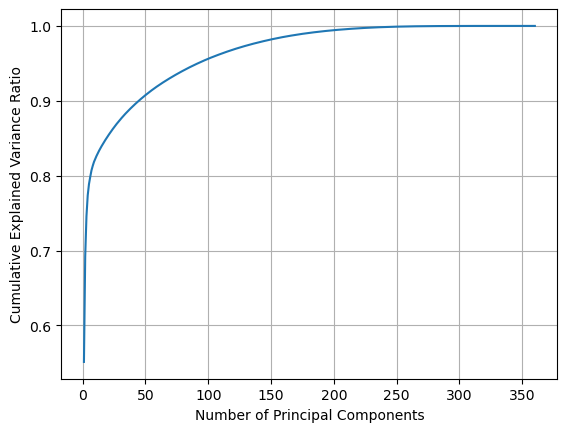

In [29]:
optimal_n_components = find_optimal_no_components(data_samples, threshold=0.8)

Shape of the data before PCA: (2880, 360)
Shape of the data after PCA: (2880, 7)


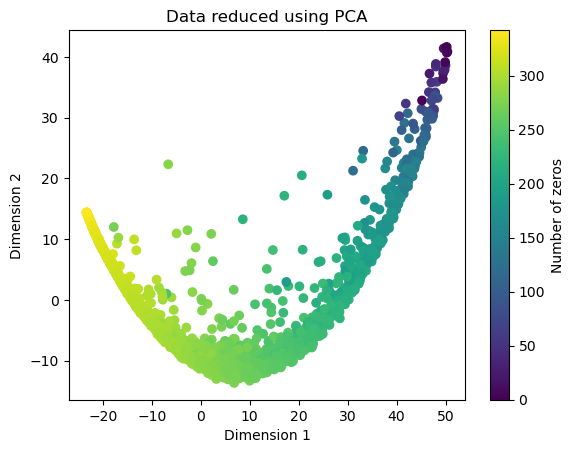

In [30]:
data_samples_reduced_pca = reduce_dimensions(data_samples, n_components=optimal_n_components)
plot_reduced_data(data_samples_reduced_pca[:, 0], data_samples_reduced_pca[:, 1], method="PCA", color=no_zeros, color_label="Number of zeros")

### t-SNE (t-distributed stochastic neighbor embedding)

t-SNE is a dimensionality reduction technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. It is particularly useful for exploring complex datasets with many features, where traditional visualization techniques like scatter plots or histograms are not effective.

t-SNE works by constructing a probability distribution over pairs of high-dimensional objects, such that similar objects have a high probability of being chosen, while dissimilar objects have a low probability. This probability distribution is then compared to a similar probability distribution over pairs of objects in a lower-dimensional space, and the difference between the two is minimized using gradient descent.


Shape of the data before t-SNE: (2880, 360)
Shape of the data after t-SNE: (2880, 2)


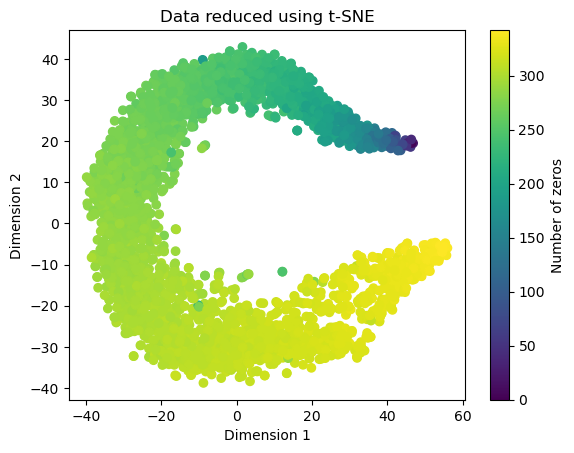

In [86]:
data_samples_reduced_tsne = reduce_dimensions(data_samples, n_components=2, method='t-SNE')
plot_reduced_data(data_samples_reduced_tsne[:, 0], data_samples_reduced_tsne[:, 1], method="t-SNE", color=no_zeros, color_label="Number of zeros")

### Non-linear PCA with autoencoder neural network

Nonlinear principal component analysis (NLPCA) is commonly seen as a nonlinear generalization of standard principal component analysis (PCA). It generalizes the principal components from straight lines to curves (nonlinear).

Nonlinear PCA can be achieved by using a neural network with an autoassociative architecture also known as autoencoder, replicator network, bottleneck or sandglass type network. 

An autoencoder is a neural network that is trained to reconstruct its own input (that is, to find the identity function f(x) = x). You put in an input (e.g. (1, 2, 3)) and penalize it if it outputs anything but (1, 2, 3).

You typically do not look at the output layer, you look at (one of) the hidden layer(s). Once the network can reliably reconstruct its input, the hidden layer must contain enough information to represent the output. If the hidden layer is smaller than the input/output layers, what it represents is the same information in a lower dimensionality. 

This introduces a "bottleneck" in the network that forces it to learn the most important features of the input data in order to reconstruct it accurately:

- An input is fed into the encoder part of the network.

- The encoder learns to represent the input using a compact code (a lower-dimensional latent space).

- The decoder tries to reconstruct the original input from that compact code.

- The network is trained by minimizing the difference between the original input and the reconstructed output.

- This forces the network to learn the most important features that allow it to accurately reconstruct the input, despite the information loss due to the bottleneck.

Shape of the data before autoencoder: (2880, 360)
Shape of the data after autoencoder: (2880, 2)


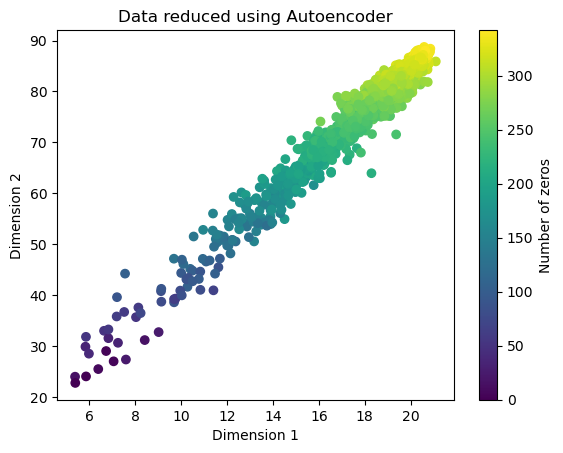

In [72]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model

data_samples_reduced_autoencoder = reduce_dimensions(data_samples, n_components=2, method='autoencoder')

plot_reduced_data(data_samples_reduced_autoencoder[:, 0], data_samples_reduced_autoencoder[:, 1], method="Autoencoder", color=no_zeros, color_label="Number of zeros")

### K-means algorthim with PCA
We start with the k-means algorithm as a baseline clustering approach for its simplicity and ease of implementation, providing initial insights into the data.

The main element of the algorithm works by a two-step process called **expectation-maximization**. The **expectation** step assigns each data point to its nearest centroid. Then, the **maximization** step computes the mean of all the points for each cluster and sets the new centroid

#### Step-by-step overview of how the K-means algorithm works:

- **Initialization**: Select K - the number of initial centroids. You can select it randomly or using some heuristic. Each centroid represents the center of a cluster.

- **Assignment**: Assign each data sample to the nearest centroid based on a distance metric, usually the Euclidean distance. This step forms K clusters.

- **Update**: Recalculate the centroids by taking the mean of all the data samples assigned to each cluster.

- **Reassignment**: Repeat steps 2 and 3 until convergence. Convergence occurs when the centroids no longer change significantly or when a maximum number of iterations is reached.

- **Output**: Once the algorithm converges, the final clusters are obtained. Each data sample belongs to the cluster associated with its nearest centroid.

#### Finding optimal value of k clusters using Elbow Method and Silhouette Coefficient Method

These methods are often used as complementary evaluation techniques rather than one being preferred over the other. Here is how they work:

**Elbow Method:** When plotting sum of squared errors (SSE) as a function of the number of clusters, the SSE continues to decrease as k increases. As more centroids are added, the distance from each point to its closest centroid will decrease. There’s a sweet spot where the SSE curve starts to bend known as the **elbow point**. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters.

**Silhouette Coefficient Method:** It is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
- How **close** the data point is to other points in **the cluster**
- How **far** away the data point is from points in **other clusters**

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

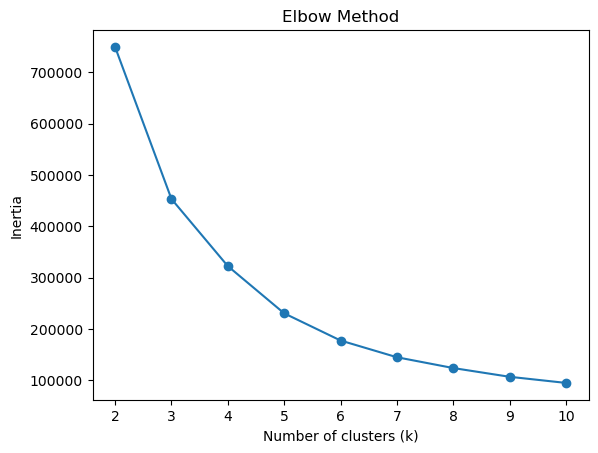

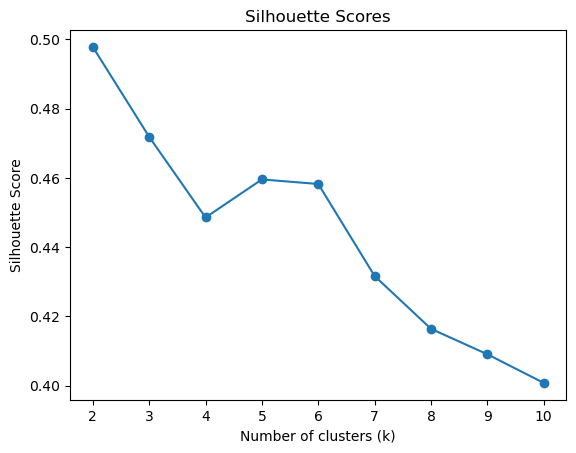

In [21]:
find_optimal_k(data_samples_reduced_pca)

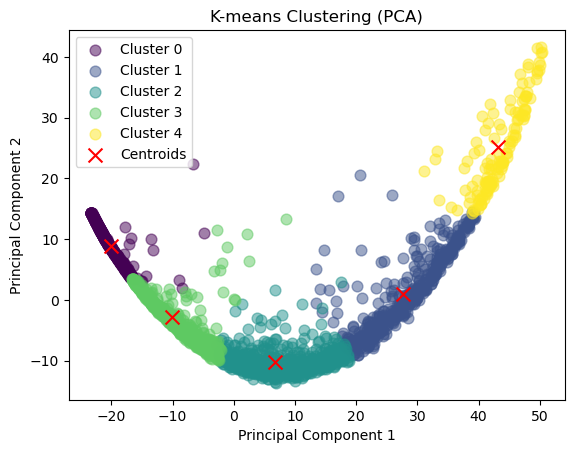

Cluster 0:
 Size: 712

Cluster 1:
 Size: 448

Cluster 2:
 Size: 739

Cluster 3:
 Size: 854

Cluster 4:
 Size: 127



In [84]:
optimal_no_clusters_pca = 5

# PCA
cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_reduced_pca, optimal_no_clusters_pca)

plot_k_means_clusters(data_samples_reduced_pca, cluster_labels, cluster_centers, title="K-means Clustering (PCA)")

analyze_clusters(file_names, data_samples, cluster_labels, optimal_no_clusters_pca, n_samples=0, visualise_mean_variance=False)

#### K-means algorthim with t-SNE

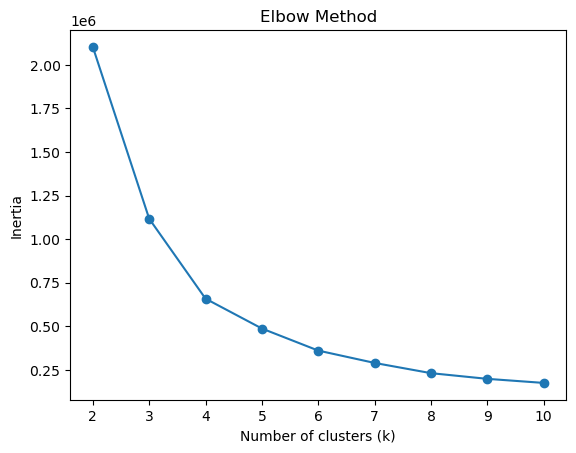

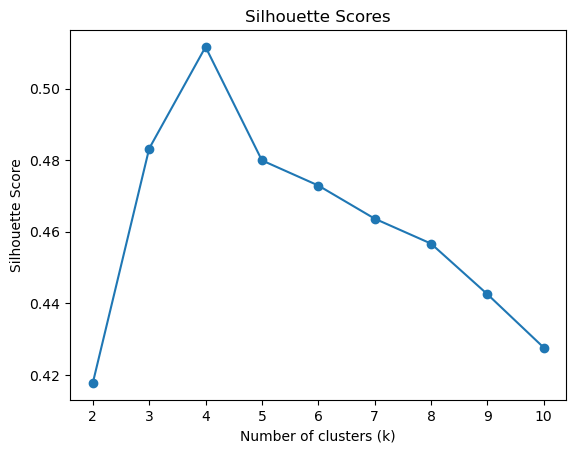

In [23]:
find_optimal_k(data_samples_reduced_tsne)

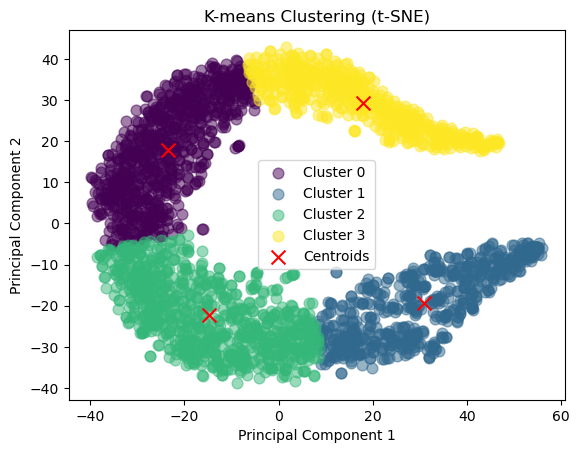

Cluster 0:
 Size: 784

Cluster 1:
 Size: 653

Cluster 2:
 Size: 848

Cluster 3:
 Size: 595



In [89]:
optimal_no_clusters_tsne = 4
# t-SNE
cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_reduced_tsne, optimal_no_clusters_tsne)

plot_k_means_clusters(data_samples_reduced_tsne, cluster_labels, cluster_centers, title="K-means Clustering (t-SNE)")

analyze_clusters(file_names, data_samples, cluster_labels, optimal_no_clusters_tsne, n_samples=0, visualise_mean_variance=False)

#### K-means algorithm with autoencoder

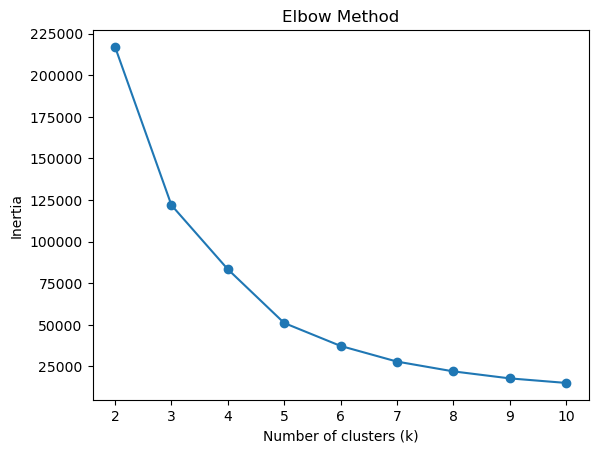

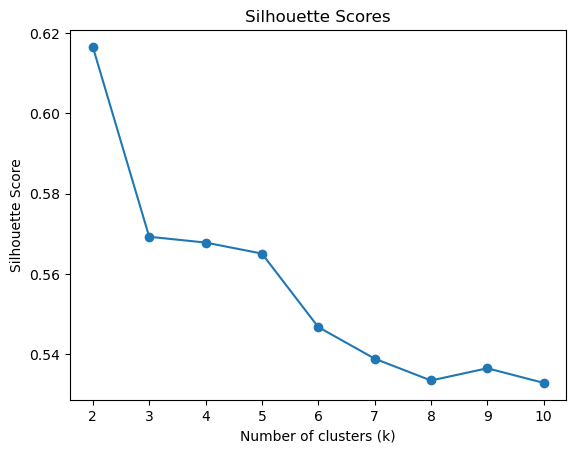

In [ ]:
find_optimal_k(data_samples_reduced_autoencoder)

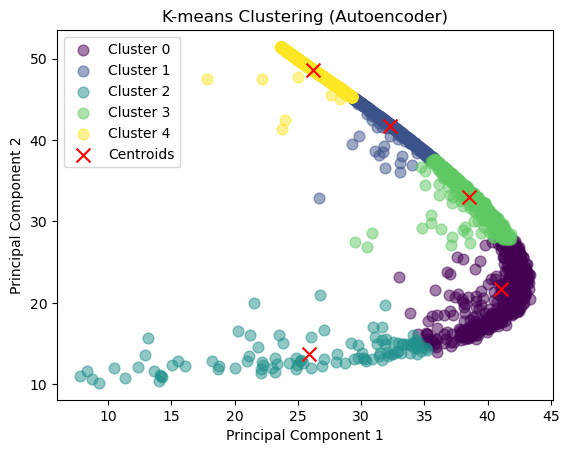

Cluster 0:
 Size: 546

Cluster 1:
 Size: 702

Cluster 2:
 Size: 100

Cluster 3:
 Size: 655

Cluster 4:
 Size: 877



In [90]:
optimal_no_clusters_autoencoder = 5
# Autoencoder
cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_reduced_autoencoder, optimal_no_clusters_autoencoder)

plot_k_means_clusters(data_samples_reduced_autoencoder, cluster_labels, cluster_centers, title="K-means Clustering (Autoencoder)")

analyze_clusters(file_names, data_samples, cluster_labels, optimal_no_clusters_autoencoder, n_samples=0, visualise_mean_variance=False)

#### Clustering one x-axis bin at the time

To deal with high dimensionality of our data (each data sample is [12, 40]) another thing we might want to try is to analyze one bin on the x-axis at a time, resulting in 12 1D arrays with 40 columns each. We will reduce and plot each bin separately.

Number of data samples: 2880
The shape of the data: (2880, 9, 40)
1D array shape: (2880, 40)
Number of 1D arrays: 9
Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


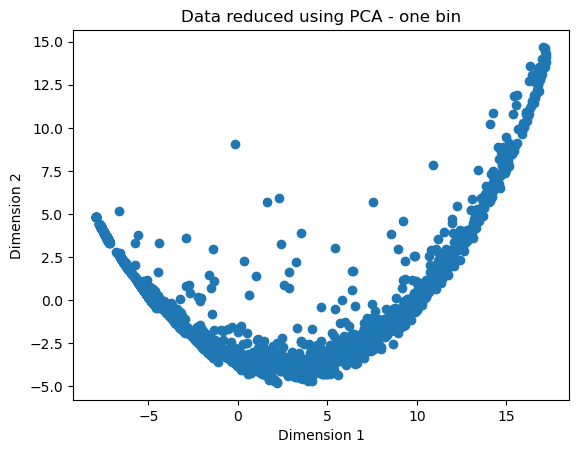

In [26]:
raw_data, file_names = load_data_samples(data_dir, 'I', log_transform=True)

array_to_eval = 5
arrays_1D = [raw_data[:, i, :] for i in range(9)]
print("1D array shape: {}".format(arrays_1D[array_to_eval].shape))
print("Number of 1D arrays: {}".format(len(arrays_1D)))

array_1d_reduced_pca = reduce_dimensions(arrays_1D[array_to_eval], n_components=2, method='PCA')

plot_reduced_data(array_1d_reduced_pca[:, 0], array_1d_reduced_pca[:, 1], method="PCA - one bin")

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


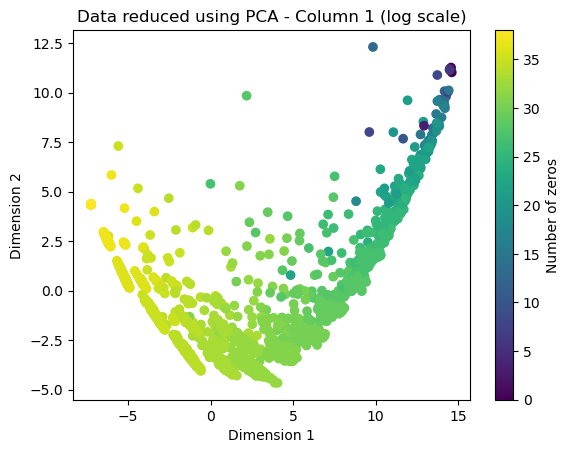

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


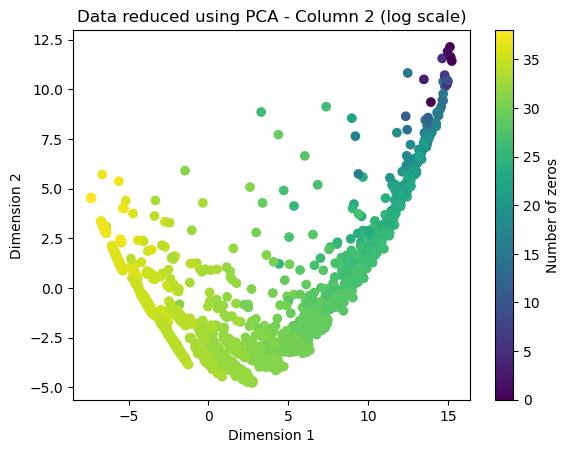

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


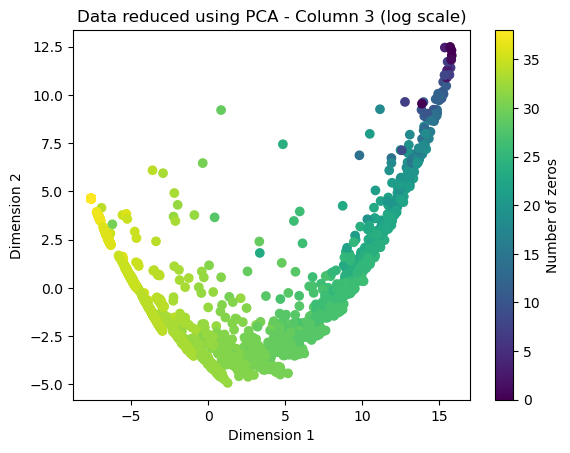

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


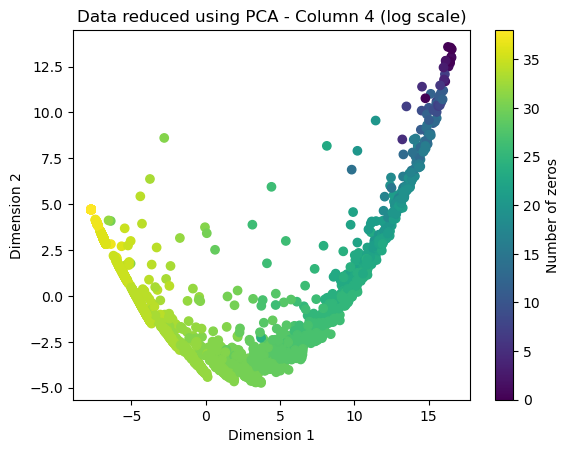

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


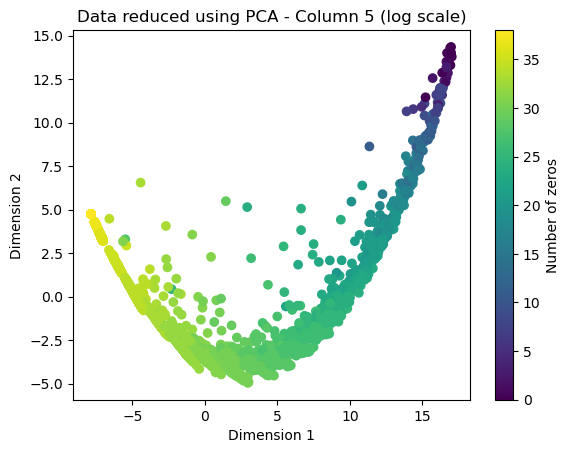

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


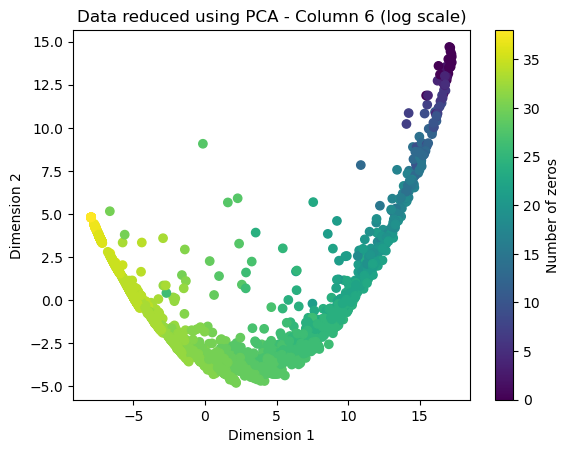

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


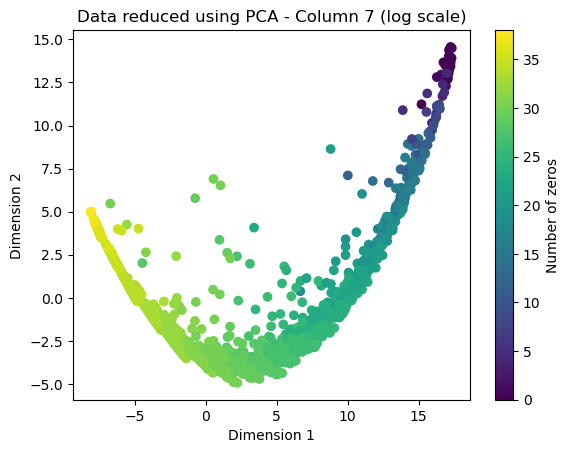

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


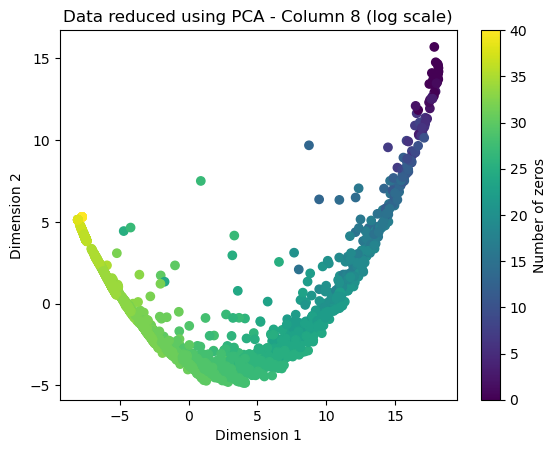

Shape of the data before PCA: (2880, 40)
Shape of the data after PCA: (2880, 2)


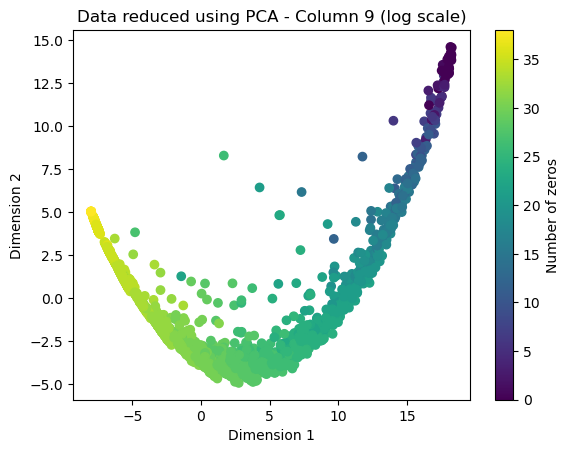

In [29]:
# Raw data shape is (2880, 9, 40)
# Loop over each column in the raw data
for i in range(raw_data.shape[1]):
    # Extract the i-th column from each sample to create a 2D array
    column_i = raw_data[:, i, :]
    # Count the number of zeros in the column for each data sample
    n_zeros = np.sum(column_i == -7, axis=1)
    # Reduce the dimensionality of the 2D array using PCA
    column_i_reduced_pca = reduce_dimensions(column_i, n_components=2, method='PCA')

    plot_reduced_data(column_i_reduced_pca[:, 0], column_i_reduced_pca[:, 1], method="PCA - Column {} (log scale)".format(i+1), color=n_zeros, color_label="Number of zeros")

    # cluster_labels, cluster_centers = perform_kmeans_clustering(column_reduced)
    # plot_k_means_clusters(column_reduced, cluster_labels, cluster_centers, title="K-means Clustering (Column {})".format(i+1))


### DBSCAN clustering

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It groups ‘densely grouped’ data points into a single cluster. It can identify clusters in large spatial datasets by looking at the local density of the data points. The most exciting feature of DBSCAN clustering is that it is robust to outliers. It also does not require the number of clusters to be told beforehand, unlike K-Means, where we have to specify the number of centroids.

DBSCAN requires only two parameters: epsilon and minPoints. Epsilon is the radius of the circle to be created around each data point to check the density and minPoints is the minimum number of data points required inside that circle for that data point to be classified as a Core point.

DBSCAN creates a circle of epsilon radius around every data point and classifies them into Core point, Border point, and Noise. A data point is a Core point if the circle around it contains at least ‘minPoints’ number of points. If the number of points is less than minPoints, then it is classified as Border Point, and if there are no other data points around any data point within epsilon radius, then it treated as Noise.

Number of clusters: 6
Number of noise points: 223


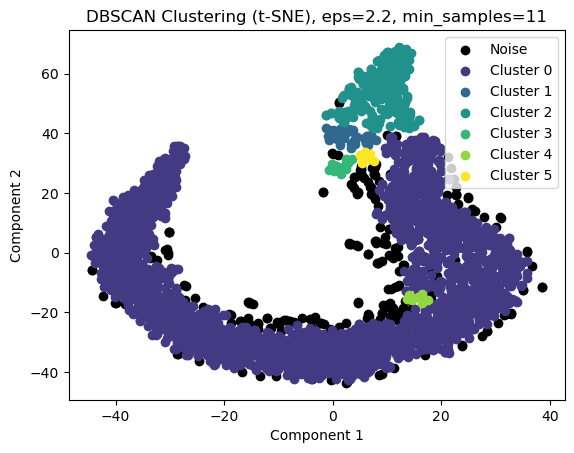

Cluster 0:
  Size: 2273

Cluster 1:
  Size: 58

Cluster 2:
  Size: 287

Cluster 3:
  Size: 18

Cluster 4:
  Size: 10

Cluster 5:
  Size: 11



In [28]:
eps_value = 2.2
min_samples = 11

# Feeding reduced data to DBSCAN
cluster_labels, n_clusters, n_noise = apply_dbscan(data_samples_reduced_tsne, eps_value, min_samples)

print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

# visualise the clusters
unique_labels = np.unique(cluster_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

# Custom names for the legend
cluster_names = ['Noise'] + [f'Cluster {i}' for i in range(len(unique_labels) - 1)]

for label, col in zip(unique_labels, colors):
    if label == -1:
        # Noise points are colored black
        col = np.array([[0, 0, 0, 1]])  # RGBA for black color
    else:
        col = col[np.newaxis, :]
        
    class_member_mask = (cluster_labels == label)
    xy = data_samples_reduced_tsne[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(cluster_names)
plt.title(f'DBSCAN Clustering (t-SNE), eps={eps_value}, min_samples={min_samples}')
plt.show()

analyze_clusters(file_names, data_samples, cluster_labels, n_clusters, n_samples=0, visualise_mean_variance=False)


### Validating clusters

We will explore the validity of the clusters obtained from a k-means clustering algorithm by using different dimensionality reduction techniques as preprocessing steps. By comparing the results of the clustering on the reduced data sets, we can identify patterns in the data and evaluate the consistency and robustness of the clusters. This approach can help us gain insights into the underlying structure of the data and validate the effectiveness of the clustering algorithm.

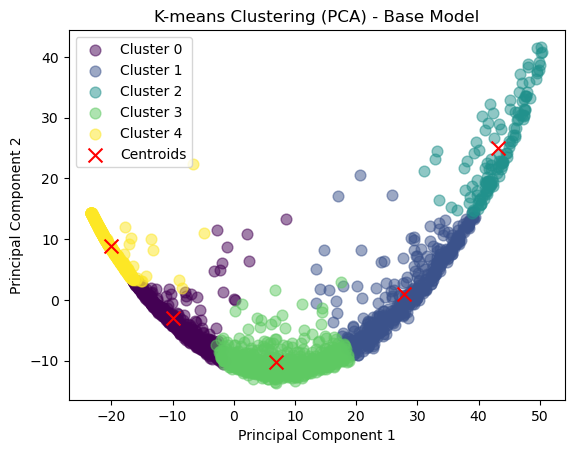

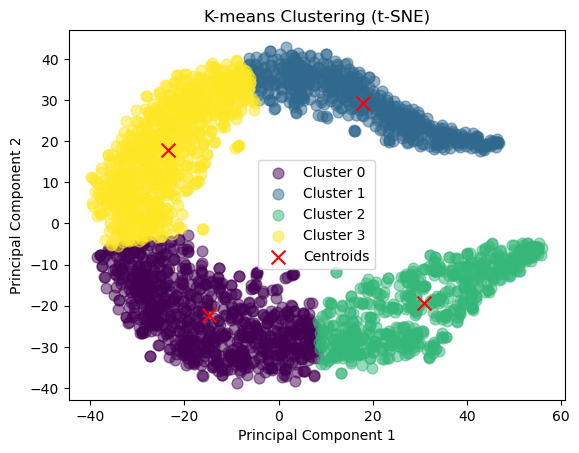

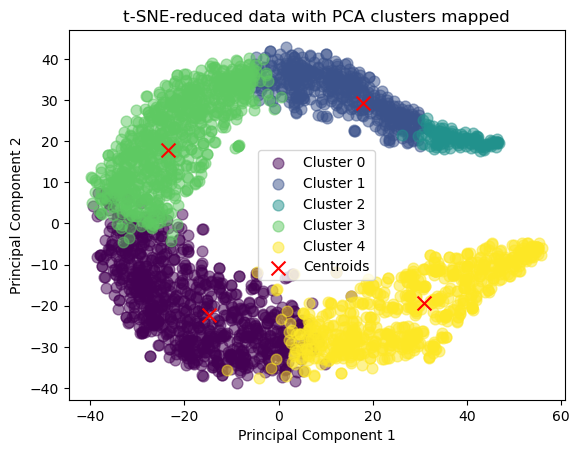

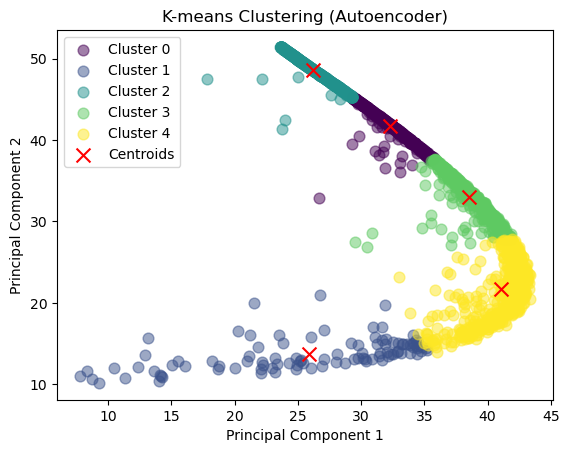

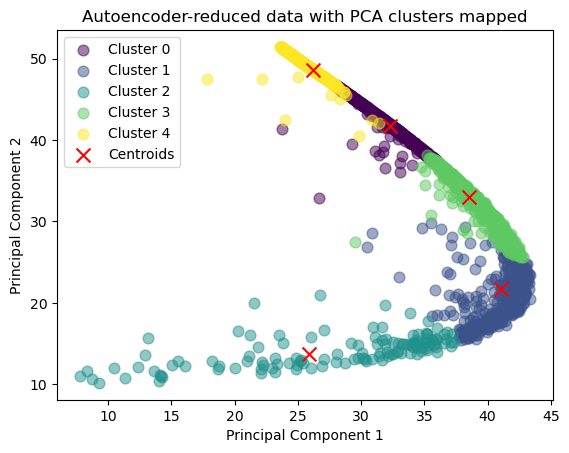

In [91]:
# Apply k-means clustering to the PCA-reduced data and plot the clusters
# Base model for comparison
cluster_labels_pca, cluster_centers_pca = perform_kmeans_clustering(data_samples_reduced_pca, optimal_no_clusters_pca)
plot_k_means_clusters(data_samples_reduced_pca, cluster_labels_pca, cluster_centers_pca, title="K-means Clustering (PCA) - Base Model")


# Apply k-means clustering to the t-SNE-reduced data and plot the clusters
cluster_labels_tsne, cluster_centers_tsne = perform_kmeans_clustering(data_samples_reduced_tsne, optimal_no_clusters_tsne)
plot_k_means_clusters(data_samples_reduced_tsne, cluster_labels_tsne, cluster_centers_tsne, title="K-means Clustering (t-SNE)")
# Plot the t-SNE-reduced data with mapping of PCA-reduced clusters
plot_k_means_clusters(data_samples_reduced_tsne, cluster_labels_pca, cluster_centers_tsne,
                      title='t-SNE-reduced data with PCA clusters mapped')


# Apply k-means clustering to the autoencoder-reduced data and plot the clusters
cluster_labels_autoencoder, cluster_centers_autoencoder = perform_kmeans_clustering(data_samples_reduced_autoencoder, optimal_no_clusters_autoencoder)
plot_k_means_clusters(data_samples_reduced_autoencoder, cluster_labels_autoencoder, cluster_centers_autoencoder, title="K-means Clustering (Autoencoder)")
# Plot the autoencoder-reduced data with mapping of PCA-reduced clusters
plot_k_means_clusters(data_samples_reduced_autoencoder, cluster_labels_pca, cluster_centers_autoencoder,
                      title='Autoencoder-reduced data with PCA clusters mapped')

## Comparing methods and analysing results

To advance the analysis, we will now compare the different dimensionality reduction and clustering techniques applied to the data. This comparison will provide insights into how the combinations of dimensionality reduction and clustering methods perform compared to each other. We will also try to investigate which techniques produce the most meaningful information and how they differ.


---
### Filter I
---

### Importing data

In [59]:
results_folder = 'Weekly Reports/Week 4/results/filter_I'

data_samples_flattened, file_names = load_data_samples(data_dir, 'I', flatten=True, log_transform=True)
no_zeros_flattened = count_zeros(data_samples_flattened, -7)

data_samples_raw, file_names = load_data_samples(data_dir, 'I', flatten=False, log_transform=True)
# First column
column_index_first = 0
data_samples_column_first = data_samples_raw[:, column_index_first, :]
no_zeros_column_first = count_zeros(data_samples_column_first, -7)
# Middle column
column_index_middle = 4
data_samples_column_middle = data_samples_raw[:, column_index_middle, :]
no_zeros_column_middle = count_zeros(data_samples_column_middle, -7)
# Last column
column_index_last = 8
data_samples_column_last = data_samples_raw[:, column_index_last, :]
no_zeros_column_last = count_zeros(data_samples_column_last, -7)

number_of_components = 2

number_of_clusters = 5

Number of data samples: 2880
The shape of the data: (2880, 360)
Number of data samples: 2880
The shape of the data: (2880, 9, 40)


### PCA - whole dataset

Shape of the data before PCA: (2880, 360)


Shape of the data after PCA: (2880, 2)


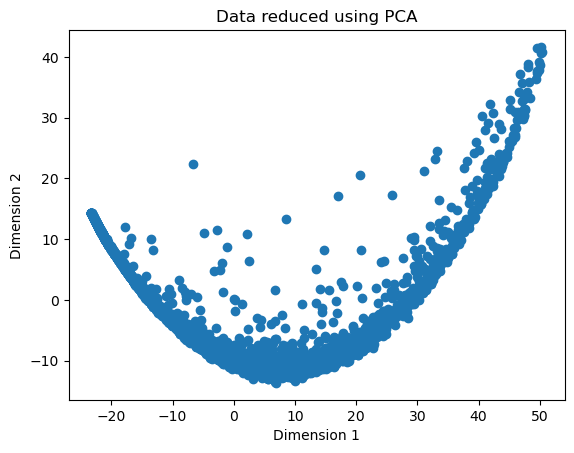

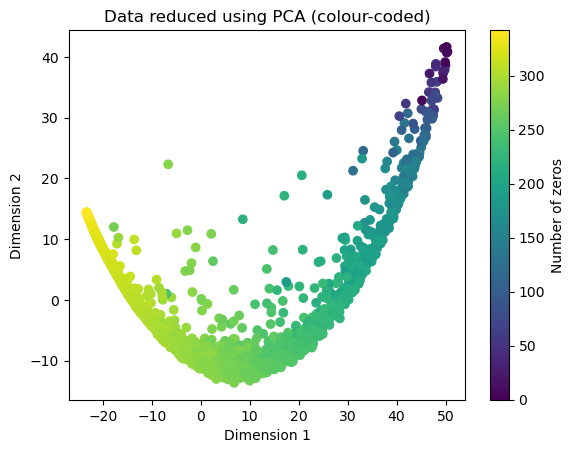

In [17]:
data_samples_flattened_reduced_pca = reduce_dimensions(data_samples_flattened, n_components=number_of_components)
plot_reduced_data(data_samples_flattened_reduced_pca[:, 0], data_samples_flattened_reduced_pca[:, 1], method="PCA")
plot_reduced_data(data_samples_flattened_reduced_pca[:, 0], data_samples_flattened_reduced_pca[:, 1], method="PCA (colour-coded)", color=no_zeros_flattened, color_label="Number of zeros")

### PCA - whole dataset - K-means

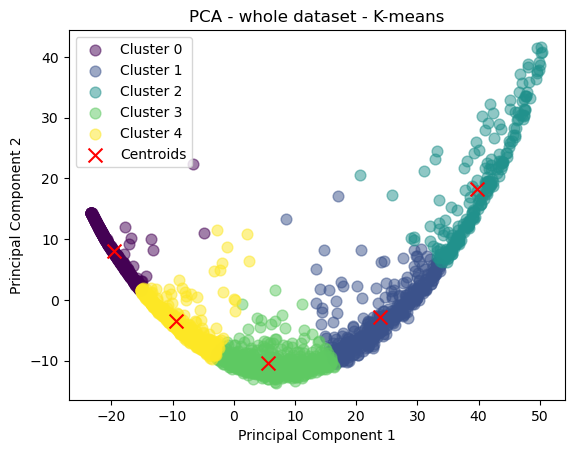

In [114]:
# PCA
cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_flattened_reduced_pca, number_of_clusters)

plot_k_means_clusters(data_samples_flattened_reduced_pca, cluster_labels, cluster_centers, title="PCA - whole dataset - K-means")
evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/PCA/dataset/kmeans', n_samples=5)

### PCA - whole dataset - DBSCAN

Number of noise points: 111


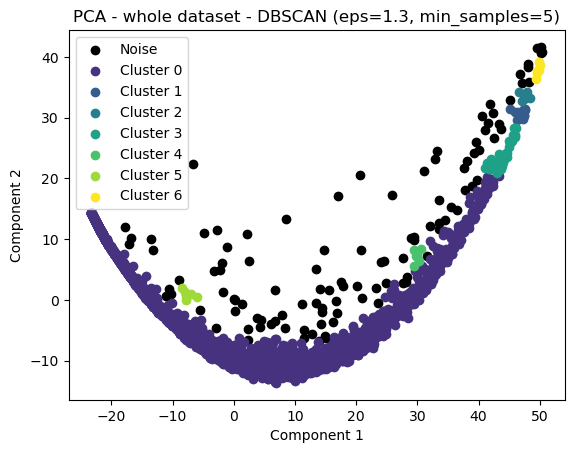

In [115]:
eps_value = 1.3
min_samples = 5

cluster_labels, n_clusters, n_noise = apply_dbscan(data_samples_flattened_reduced_pca, eps_value, min_samples)

plot_dbscan_clusters(data_samples_flattened_reduced_pca, cluster_labels, n_noise, eps_value, min_samples, title="PCA - whole dataset - DBSCAN")
evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/PCA/dataset/dbscan', n_samples=5)

### t-SNE - whole dataset

Shape of the data before t-SNE: (2880, 360)
Shape of the data after t-SNE: (2880, 2)


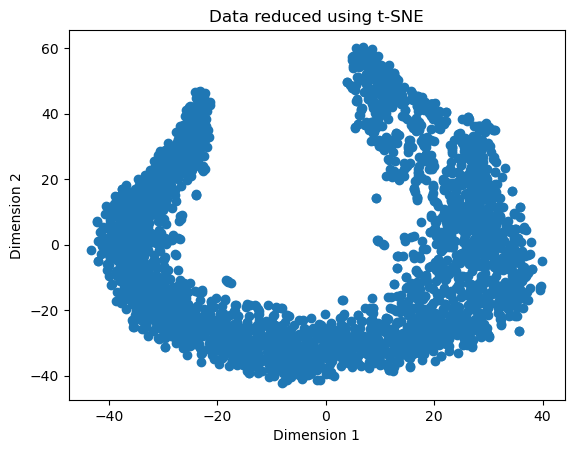

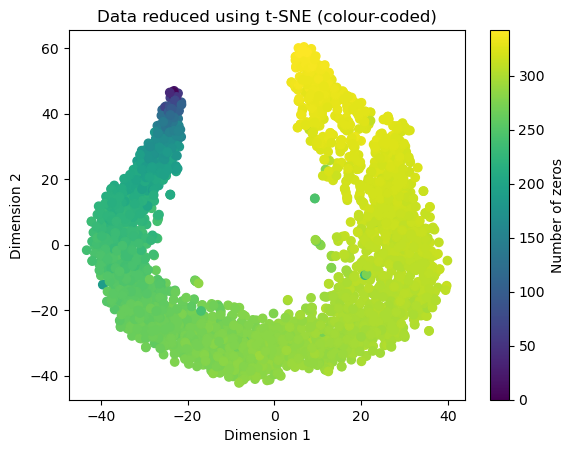

In [116]:
data_samples_flattened_reduced_tsne = reduce_dimensions(data_samples_flattened, n_components=number_of_components, method='t-SNE')
plot_reduced_data(data_samples_flattened_reduced_tsne[:, 0], data_samples_flattened_reduced_tsne[:, 1], method="t-SNE")
plot_reduced_data(data_samples_flattened_reduced_tsne[:, 0], data_samples_flattened_reduced_tsne[:, 1], method="t-SNE (colour-coded)", color=no_zeros_flattened, color_label="Number of zeros")

### PCA - whole dataset - t-SNE

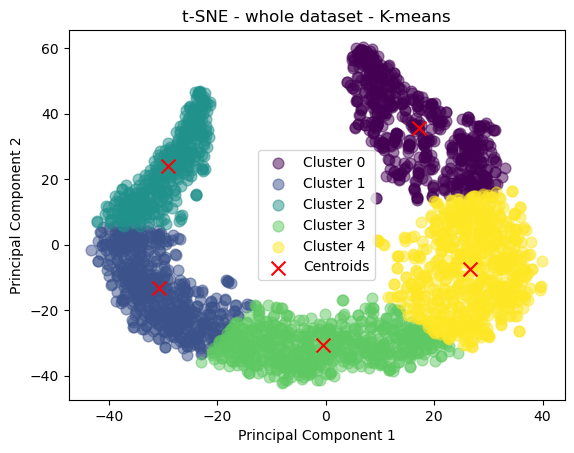

In [117]:
# t-SNE
cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_flattened_reduced_tsne, number_of_clusters)

plot_k_means_clusters(data_samples_flattened_reduced_tsne, cluster_labels, cluster_centers, title="t-SNE - whole dataset - K-means")
evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/t-SNE/dataset/kmeans', n_samples=5)

### DBSCAN - whole dataset - t-SNE

Number of noise points: 149


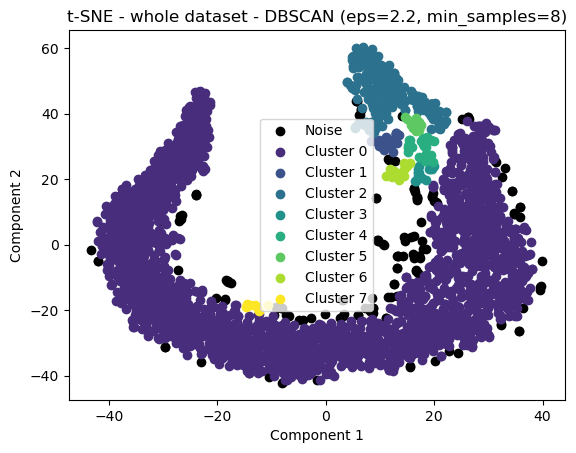

In [121]:
eps_value = 2.2
min_samples = 8

cluster_labels, n_clusters, n_noise = apply_dbscan(data_samples_flattened_reduced_tsne, eps_value, min_samples)

plot_dbscan_clusters(data_samples_flattened_reduced_tsne, cluster_labels, n_noise, eps_value, min_samples, title="t-SNE - whole dataset - DBSCAN")
evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/t-SNE/dataset/dbscan', n_samples=5)

### Autoencoder - whole dataset

Shape of the data before autoencoder: (2880, 360)
90/90 [==============================] - 0s 2ms/step
Shape of the data after autoencoder: (2880, 2)
Shape of the data before autoencoder: (2880, 360)
90/90 [==============================] - 0s 1ms/step
Shape of the data after autoencoder: (2880, 2)
Shape of the data before autoencoder: (2880, 360)
90/90 [==============================] - 1s 1ms/step
Shape of the data after autoencoder: (2880, 2)


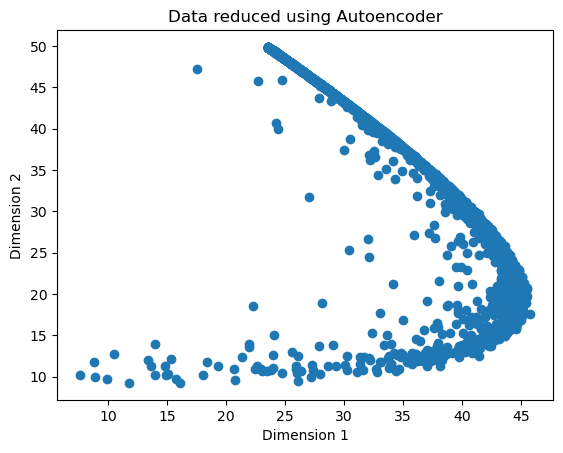

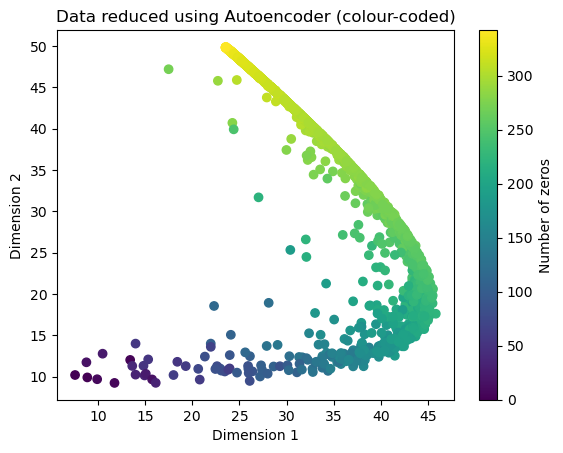

In [123]:
data_samples_flattened_reduced_autoencoder = reduce_dimensions(data_samples_flattened, n_components=number_of_components, method='autoencoder')

plot_reduced_data(data_samples_flattened_reduced_autoencoder[:, 0], data_samples_flattened_reduced_autoencoder[:, 1], method="Autoencoder")
plot_reduced_data(data_samples_flattened_reduced_autoencoder[:, 0], data_samples_flattened_reduced_autoencoder[:, 1], method="Autoencoder (colour-coded)", color=no_zeros_flattened, color_label="Number of zeros")

### PCA - whole dataset - Autoencoder

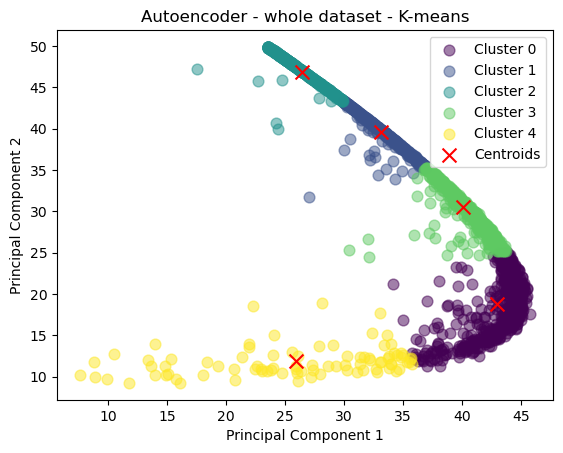

In [124]:
# Autoencoder
cluster_labels, cluster_centers = perform_kmeans_clustering(data_samples_flattened_reduced_autoencoder, number_of_clusters)

plot_k_means_clusters(data_samples_flattened_reduced_autoencoder, cluster_labels, cluster_centers, title="Autoencoder - whole dataset - K-means")
evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/Autoencoder/dataset/kmeans', n_samples=5)

### DBSCAN - whole dataset - Autoencoder

Number of noise points: 50


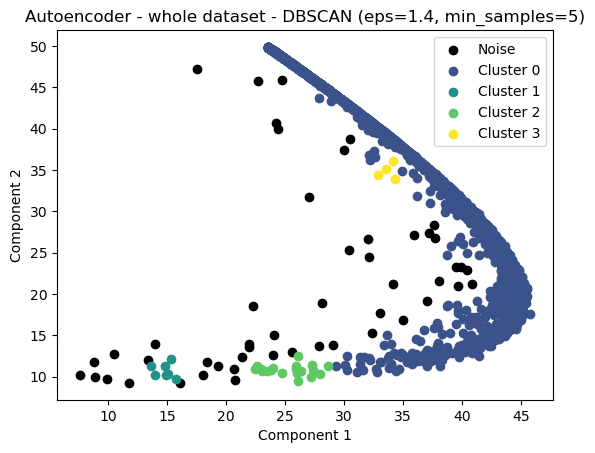

In [134]:
eps_value = 1.4
min_samples = 5

cluster_labels, n_clusters, n_noise = apply_dbscan(data_samples_flattened_reduced_autoencoder, eps_value, min_samples)

plot_dbscan_clusters(data_samples_flattened_reduced_autoencoder, cluster_labels, n_noise, eps_value, min_samples, title="Autoencoder - whole dataset - DBSCAN")
evaluate_clusters_and_save_results(data_samples_raw, file_names, cluster_labels, f'{results_folder}/Autoencoder/dataset/dbscan', n_samples=4)

### Investigaing one column at a time

#### First column

In [ ]:
analyze_data_samples(data_samples_column_first, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_first, results_folder, 'column_first')

#### Middle column

In [ ]:
analyze_data_samples(data_samples_column_middle, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_middle, results_folder, 'column_middle')

#### Last column

In [ ]:
analyze_data_samples(data_samples_column_last, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_last, results_folder, 'column_last')

---
### Filter R
---

In [79]:
results_folder = 'Weekly Reports/Week 4/results/filter_R'

data_samples_flattened, file_names = load_data_samples(data_dir, 'R', flatten=True, log_transform=True)
no_zeros_flattened = count_zeros(data_samples_flattened, -7)

data_samples_raw, file_names = load_data_samples(data_dir, 'R', flatten=False, log_transform=True)
# First column
column_index_first = 0
data_samples_column_first = data_samples_raw[:, column_index_first, :]
no_zeros_column_first = count_zeros(data_samples_column_first, -7)
# Middle column
column_index_middle = 4
data_samples_column_middle = data_samples_raw[:, column_index_middle, :]
no_zeros_column_middle = count_zeros(data_samples_column_middle, -7)
# Last column
column_index_last = 8
data_samples_column_last = data_samples_raw[:, column_index_last, :]
no_zeros_column_last = count_zeros(data_samples_column_last, -7)

number_of_components = 2

number_of_clusters = 5

Number of data samples: 2880
The shape of the data: (2880, 360)
Number of data samples: 2880
The shape of the data: (2880, 9, 40)


In [ ]:
analyze_data_samples(data_samples_flattened, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_last, results_folder, 'dataset')
analyze_data_samples(data_samples_column_first, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_first, results_folder, 'column_first')
analyze_data_samples(data_samples_column_middle, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_middle, results_folder, 'column_middle')
analyze_data_samples(data_samples_column_last, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_last, results_folder, 'column_last')

---
### Filter V
---

In [81]:
results_folder = 'Weekly Reports/Week 4/results/filter_V'

data_samples_flattened, file_names = load_data_samples(data_dir, 'V', flatten=True, log_transform=True)
no_zeros_flattened = count_zeros(data_samples_flattened, -7)

data_samples_raw, file_names = load_data_samples(data_dir, 'V', flatten=False, log_transform=True)
# First column
column_index_first = 0
data_samples_column_first = data_samples_raw[:, column_index_first, :]
no_zeros_column_first = count_zeros(data_samples_column_first, -7)
# Middle column
column_index_middle = 4
data_samples_column_middle = data_samples_raw[:, column_index_middle, :]
no_zeros_column_middle = count_zeros(data_samples_column_middle, -7)
# Last column
column_index_last = 8
data_samples_column_last = data_samples_raw[:, column_index_last, :]
no_zeros_column_last = count_zeros(data_samples_column_last, -7)

number_of_components = 2

number_of_clusters = 5

Number of data samples: 2880
The shape of the data: (2880, 360)
Number of data samples: 2880
The shape of the data: (2880, 9, 40)


In [ ]:
analyze_data_samples(data_samples_flattened, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_last, results_folder, 'dataset')
analyze_data_samples(data_samples_column_first, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_first, results_folder, 'column_first')
analyze_data_samples(data_samples_column_middle, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_middle, results_folder, 'column_middle')
analyze_data_samples(data_samples_column_last, data_samples_raw, number_of_components, number_of_clusters, no_zeros_column_last, results_folder, 'column_last')

### Analysing t-SNE reduced data

An analysis of t-SNE reduced data (applied on a single column) has revealed interesting patterns. Unlike other dimensionality reduction techniques, t-SNE has distinguished clusters in the scatter plot. Further analysis of these clusters has been conducted and the results are presented below.

In [19]:
data, file_names = load_data_samples(data_dir, 'I', log_transform=True)

Number of data samples: 2880
The shape of the data: (2880, 9, 40)


In [ ]:
arrays_1D = [data[:, i, :] for i in range(9)]
print("Single column shape: {}".format(arrays_1D[0].shape))
print("Number of columns: {}".format(len(arrays_1D)))

# Data shape is (2880, 9, 40)
# Loop over each column in the data
for i in range(data.shape[1]):
    # Extract the i-th column from each sample to create a 2D array
    column_i = data[:, i, :]
    # Count the number of zeros in the column for each data sample
    n_zeros = count_zeros(column_i, -7)
    # Reduce the dimensionality of the 2D array using PCA
    column_i_reduced_tsne = reduce_dimensions(column_i, n_components=2, method='t-SNE', init='pca')

    plot_reduced_data(column_i_reduced_tsne[:, 0], column_i_reduced_tsne[:, 1], method="t-SNE - Column {}".format(i+1), color=n_zeros, color_label="Number of zeros", save_path="Weekly Reports/Week 5/t-SNE/Column {}.png".format(i+1))

Shape of the data before t-SNE: (2880, 40)


d:\Programy\Miniconda\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Shape of the data after t-SNE: (2880, 2)


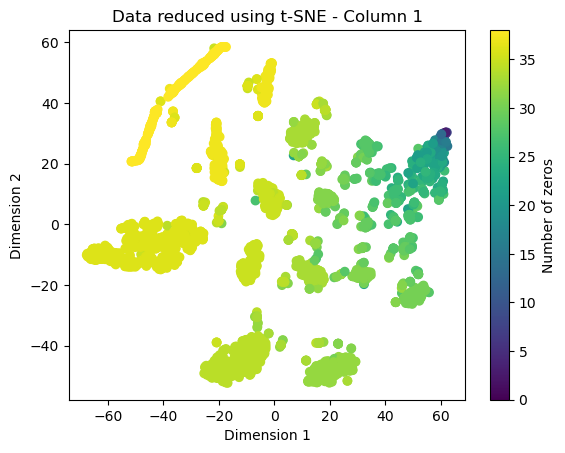

In [20]:
column_0 = data[:, 0, :]
n_zeros = count_zeros(column_0, -7)
column_0_reduced_tsne = reduce_dimensions(column_0, n_components=2, method='t-SNE', init='pca')

plot_reduced_data(column_0_reduced_tsne[:, 0], column_0_reduced_tsne[:, 1], method="t-SNE - Column 1", color=n_zeros, color_label="Number of zeros")

Number of noise points: 10


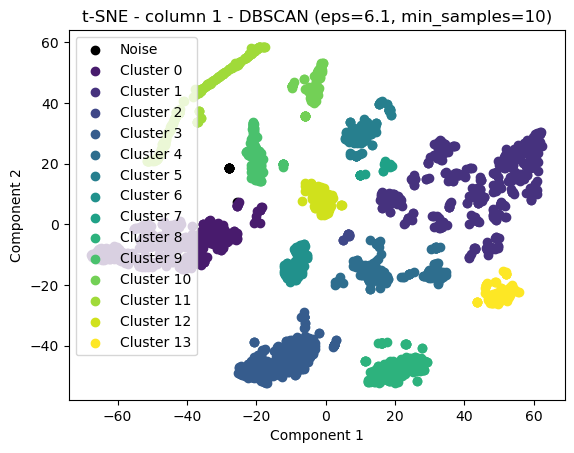

In [22]:
eps_value = 6.1
min_samples = 10

labels, clusters, noise = apply_dbscan(column_0_reduced_tsne, eps_value, min_samples)

plot_dbscan_clusters(column_0_reduced_tsne, labels, noise, eps_value, min_samples, title="t-SNE - column 1 - DBSCAN")

In [ ]:
for i in range(3):
    # Extract the i-th column from each sample to create a 2D array
    column_i = data[:, i, :]
    # Count the number of zeros in the column for each data sample
    n_zeros = count_zeros(column_i, -7)
    # Reduce the dimensionality of the 2D array using PCA
    column_i_reduced_tsne = reduce_dimensions(column_i, method='t-SNE', init='pca')

    if (i == 0):
        labels, clusters, noise = apply_dbscan(column_i_reduced_tsne, eps_value, min_samples)

    plot_dbscan_clusters(column_i_reduced_tsne, labels, noise, eps_value, min_samples, title="column 1 mapped to column {}".format(i+1))


Analysing how a single cluster is changing across columns

In [ ]:
# Extract the first column from each sample to create a 2D array
column_1 = data[:, 0, :]

# Reduce the dimensionality of the 2D array using PCA
column_1_reduced_tsne = reduce_dimensions(column_1, method='t-SNE', init='pca')

# Apply DBSCAN to cluster the first column
labels, clusters, noise = apply_dbscan(column_1_reduced_tsne, eps_value, min_samples)

unique_labels = np.unique(labels)
# Iterate over each cluster in the first column
for cluster_label in np.unique(labels):
    # Filter the data to only include the points belonging to the current cluster
    cluster_indices = np.where(labels == cluster_label)[0]
    cluster_data = data[cluster_indices, :, :]

    # Iterate over the remaining columns (2 and 3)
    for i in (0, 3):
        # Extract the i-th column from the cluster data
        column_i = data[:, i, :]

        # Reduce the dimensionality of the 2D array using PCA
        column_i_reduced_tsne = reduce_dimensions(column_i, method='t-SNE', init='pca')

        # Plot the cluster data in color and the non-cluster data in gray
        plt.scatter(column_i_reduced_tsne[:, 0], column_i_reduced_tsne[:, 1], c='gray', alpha=0.5)
        plt.scatter(column_i_reduced_tsne[cluster_indices, 0], column_i_reduced_tsne[cluster_indices, 1], c='b')

        plt.title("Column {} for cluster {}".format(i+1, cluster_label))
        plt.show()

### Analysis of the synthetic fingerprint data

With synthetic fingerprint data generated, we can gain valuable insights by comparing it to our real data. An instructive approach is to plot both datasets on the same graph, using different colors to distinguish synthetic from real data.

In [19]:
# Path to model data directory
model_data_dir = "data_model"

# Path to data directory
data_dir = "data"

# Load the model data
model_data, model_file_names = load_data_samples(model_data_dir, 'I', log_transform=True, flatten=True)
# Load the real data
real_data, real_file_names = load_data_samples(data_dir, 'I', log_transform=True, flatten=True)

n_zeros_real = count_zeros(real_data, -7)
n_zeros_model = count_zeros(model_data, -7)

Number of data samples: 2921
The shape of the data: (2921, 360)
Number of data samples: 2880
The shape of the data: (2880, 360)


Plotting the datasets separately

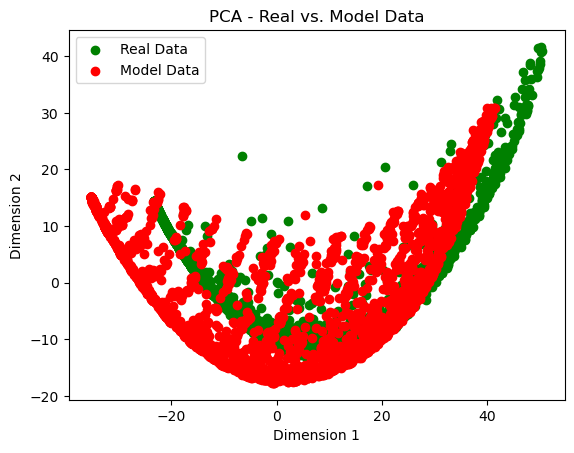

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(real_data_reduced_pca[:, 0], real_data_reduced_pca[:, 1], c='green', label="Real Data")
ax.scatter(model_data_reduced_pca[:, 0], model_data_reduced_pca[:, 1], c='red', label="Model Data")

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('PCA - Real vs. Model Data')

plt.legend()
plt.show()


In [ ]:
model_data_reduced_pca = reduce_dimensions(model_data, method='PCA')
real_data_reduced_pca = reduce_dimensions(real_data, method='PCA')
plot_reduced_data(real_data_reduced_pca[:, 0], real_data_reduced_pca[:, 1], method="PCA - Real Data", color=[n_zeros_real], color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/pca/real.png")
plot_reduced_data(model_data_reduced_pca[:, 0], model_data_reduced_pca[:, 1], method="PCA - Model Data", color=[n_zeros_model], color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/pca/model.png")
model_data_reduced_tsne = reduce_dimensions(model_data, method='t-SNE')
real_data_reduced_tsne = reduce_dimensions(real_data, method='t-SNE')
plot_reduced_data(real_data_reduced_tsne[:, 0], real_data_reduced_tsne[:, 1], method="t-SNE - Real Data", color=[n_zeros_real], color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/tsne/real.png")
plot_reduced_data(model_data_reduced_tsne[:, 0], model_data_reduced_tsne[:, 1], method="t-SNE - Model Data", color=[n_zeros_model], color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/tsne/model.png")
model_data_reduced_tsne_random = reduce_dimensions(model_data, method='t-SNE', init='random')
real_data_reduced_tsne_random = reduce_dimensions(real_data, method='t-SNE', init='random')
plot_reduced_data(real_data_reduced_tsne_random[:, 0], real_data_reduced_tsne_random[:, 1], method="t-SNE (random) - Real Data", color=[n_zeros_real], color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/tsne/real_random_init.png")
plot_reduced_data(model_data_reduced_tsne_random[:, 0], model_data_reduced_tsne_random[:, 1], method="t-SNE (random) - Model Data", color=[n_zeros_model], color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/tsne/model_random_init.png")
model_data_reduced_autoencoder = reduce_dimensions(model_data, method='autoencoder')
real_data_reduced_autoencoder = reduce_dimensions(real_data, method='autoencoder')
plot_reduced_data(real_data_reduced_autoencoder[:, 0], real_data_reduced_autoencoder[:, 1], method="Autoencoder - Real Data", color=[n_zeros_real], color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/autoencoder/real.png")
plot_reduced_data(model_data_reduced_autoencoder[:, 0], model_data_reduced_autoencoder[:, 1], method="Autoencoder - Model Data", color=[n_zeros_model], color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/autoencoder/model.png")

Merging the datasets

In [20]:
# Combine the model and real data into one array
all_data = np.concatenate((model_data, real_data), axis=0)

# Reduce the dimensionality of the combined data using PCA
all_data_reduced_pca = reduce_dimensions(all_data, method='PCA')
all_data_reduced_tsne = reduce_dimensions(all_data, method='t-SNE', init='pca')
all_data_reduced_autoencoder = reduce_dimensions(all_data, method='autoencoder')

Shape of the data before PCA: (5801, 360)
Shape of the data after PCA: (5801, 2)


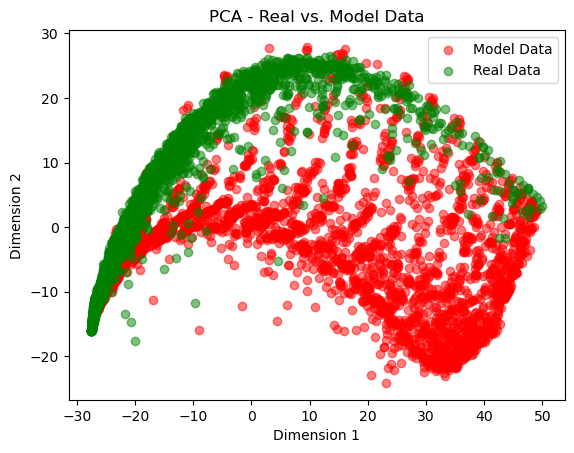

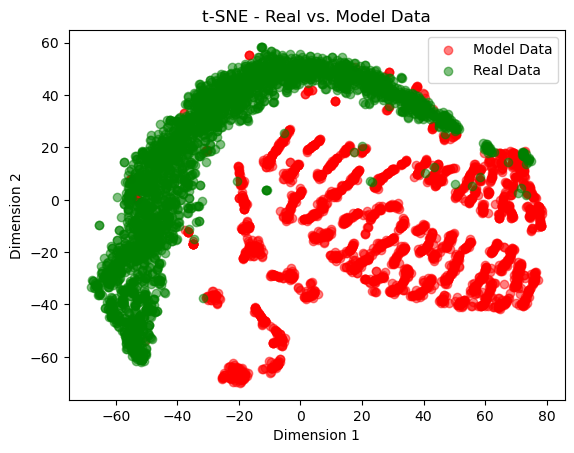

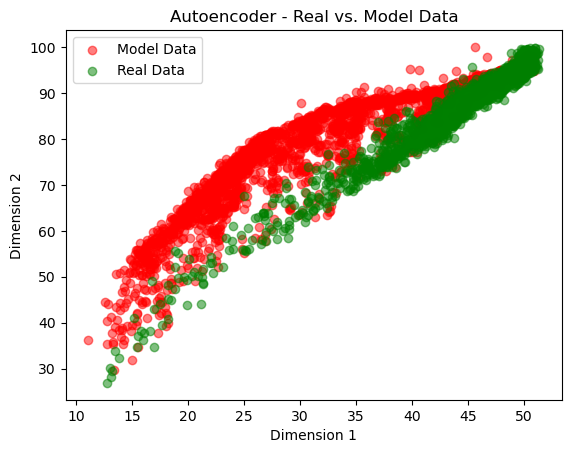

In [50]:
def plot_data(data, title):
    fig, ax = plt.subplots()
    # Plot the combined data with different colors for the model and real data points
    ax.scatter(data[:len(model_data), 0], data[:len(model_data), 1], c='red', alpha=0.5, label="Model Data")
    ax.scatter(data[len(model_data):, 0], data[len(model_data):, 1], c='green', alpha=0.5, label="Real Data")
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title(title)
    plt.legend()
    plt.savefig("Weekly Reports/Week 7/results/synthetic vs real data/{}.png".format(title))

plot_data(all_data_reduced_pca, 'PCA - Real vs. Model Data')
plot_data(all_data_reduced_tsne, 't-SNE - Real vs. Model Data')
plot_data(all_data_reduced_autoencoder, 'Autoencoder - Real vs. Model Data')

In [51]:
n_zeros = count_zeros(real_data, -7)
n_zeros_model = count_zeros(model_data, -7)# plot_reduced_data(all_data_reduced_pca[:len(model_data), 0], all_data_reduced_pca[:len(model_data), 1], method="PCA - Model Data", color=n_zeros, color_label="Number of zeros")
plot_reduced_data(all_data_reduced_pca[len(model_data):, 0], all_data_reduced_pca[len(model_data):, 1], method="PCA - Real Data", color=n_zeros, color_label="Number of zeros", save_path="Weekly Reports/Week 7/results/synthetic vs real data/PCA/Real Data - Colour Coded.png")
plot_reduced_data(all_data_reduced_pca[:len(model_data), 0], all_data_reduced_pca[:len(model_data), 1], method="PCA - Model Data", color=n_zeros_model, color_label="Number of zeros", save_path="Weekly Reports/Week 7/results/synthetic vs real data/PCA/Model Data - Colour Coded.png")
plot_reduced_data(all_data_reduced_tsne[len(model_data):, 0], all_data_reduced_tsne[len(model_data):, 1], method="t-SNE - Real Data", color=n_zeros, color_label="Number of zeros", save_path="Weekly Reports/Week 7/results/synthetic vs real data/t-SNE/Real Data - Colour Coded.png")
plot_reduced_data(all_data_reduced_tsne[:len(model_data), 0], all_data_reduced_tsne[:len(model_data), 1], method="t-SNE - Model Data", color=n_zeros_model, color_label="Number of zeros", save_path="Weekly Reports/Week 7/results/synthetic vs real data/t-SNE/Model Data - Colour Coded.png")
plot_reduced_data(all_data_reduced_autoencoder[len(model_data):, 0], all_data_reduced_autoencoder[len(model_data):, 1], method="Autoencoder - Real Data", color=n_zeros, color_label="Number of zeros", save_path="Weekly Reports/Week 7/results/synthetic vs real data/Autoencoder/Real Data - Colour Coded.png")
plot_reduced_data(all_data_reduced_autoencoder[:len(model_data), 0], all_data_reduced_autoencoder[:len(model_data), 1], method="Autoencoder - Model Data", color=n_zeros_model, color_label="Number of zeros", save_path="Weekly Reports/Week 7/results/synthetic vs real data/Autoencoder/Model Data - Colour Coded.png")

Reading synthetic data properties such as sine function **period** and **amplitude** to use it for the colour scale

In [21]:
import pandas as pd

data_folder = model_data_dir + '/'
synth_info = pd.read_csv(data_folder + 'properties_synth.txt', delimiter=' ')
synth_info.head()

amplitudes = []
periods = []

print("Number of data samples: {}".format(len(model_file_names)))

for i in range(len(model_file_names)):
    # Load the data sample file
    data_sample = np.load(data_folder + model_file_names[i])

    # Get the corresponding row from the DataFrame based on the id
    row = synth_info.loc[synth_info['id'] == int(model_file_names[i].split('_')[2])]
    
    # Extract the amplitude or period for the data sample
    amplitude = row['amp'].values[0]
    period = row['Period'].values[0]
    
    # Append the amplitude or period to the list
    amplitudes.append(amplitude)
    periods.append(period)

Number of data samples: 2921


In [23]:
plot_reduced_data(all_data_reduced_pca[:len(model_data), 0], all_data_reduced_pca[:len(model_data), 1], method="PCA - Model Data", color=amplitudes, color_label="Amplitude", save_path="Weekly Reports/Week 7/results/synthetic vs real data/PCA/Model Data - Amplitude - Inverted.png")
plot_reduced_data(all_data_reduced_tsne[:len(model_data), 0], all_data_reduced_tsne[:len(model_data), 1], method="t-SNE - Model Data", color=amplitudes, color_label="Amplitude", save_path="Weekly Reports/Week 7/results/synthetic vs real data/t-SNE/Model Data - Amplitude.png")
plot_reduced_data(all_data_reduced_autoencoder[:len(model_data), 0], all_data_reduced_autoencoder[:len(model_data), 1], method="Autoencoder - Model Data", color=amplitudes, color_label="Amplitude", save_path="Weekly Reports/Week 7/results/synthetic vs real data/Autoencoder/Model Data - Amplitude.png")

plot_reduced_data(all_data_reduced_pca[:len(model_data), 0], all_data_reduced_pca[:len(model_data), 1], method="PCA - Model Data", color=periods, color_label="Period", save_path="Weekly Reports/Week 7/results/synthetic vs real data/PCA/Model Data - Period.png")
plot_reduced_data(all_data_reduced_tsne[:len(model_data), 0], all_data_reduced_tsne[:len(model_data), 1], method="t-SNE - Model Data", color=periods, color_label="Period", save_path="Weekly Reports/Week 7/results/synthetic vs real data/t-SNE/Model Data - Period.png")
plot_reduced_data(all_data_reduced_autoencoder[:len(model_data), 0], all_data_reduced_autoencoder[:len(model_data), 1], method="Autoencoder - Model Data", color=periods, color_label="Period", save_path="Weekly Reports/Week 7/results/synthetic vs real data/Autoencoder/Model Data - Period.png")

Plotting amplitude and period together

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert periods to a NumPy array
periods = np.array(periods)

# Plotting amplitude and period together
plt.figure(figsize=(10, 8))

# Combine amplitude and period information
combined_data = np.column_stack((amplitudes, periods))

# Color-coded by amplitude, size-coded by period
scatter = plt.scatter(model_data_reduced_pca[:, 0], model_data_reduced_pca[:, 1], c=combined_data[:, 0], cmap='viridis', s=combined_data[:, 1])

# Add colorbar for amplitude
cbar = plt.colorbar(scatter)
cbar.set_label('Amplitude')

# Add legend for period size
sizes = np.unique(combined_data[:, 1])
# Crop down to only 3 sizes (smallest, middle, largest)
sizes = sizes[[0, len(sizes)//2, -1]]
# Approximate to integers
sizes = np.round(sizes).astype(int)
print(sizes)
legend = plt.legend(*scatter.legend_elements(prop='sizes', num=len(sizes) + 1), loc='upper left', title='Period', labelspacing=1.0)
for i in range(len(sizes)):
    legend.get_texts()[i].set_text(str(sizes[i]))

# Add axis labels
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.title('PCA - Model Data - Amplitude (colour) and Period (size)')

# Save the plot
plt.savefig('Weekly Reports/Week 7/results/combined_plot.png')

# Show the plot
plt.show()

Plotting real data and model data together along with all available information - number of 0s, period, and amplitude

In [156]:
# Load the model data
model_data, model_file_names = load_data_samples(model_data_dir, 'I', log_transform=False, flatten=True)
# Load the real data
real_data, real_file_names = load_data_samples(data_dir, 'I', log_transform=False, flatten=True)

n_zeros_real = count_zeros(real_data, 0)
n_zeros_model = count_zeros(model_data, 0)

# Combine the model and real data into one array
all_data = np.concatenate((model_data, real_data), axis=0)

# Reduce the dimensionality of the combined data using PCA
all_data_reduced_pca = reduce_dimensions(all_data, method='PCA')
all_data_reduced_tsne = reduce_dimensions(all_data, method='t-SNE')
all_data_reuduced_autoencoder = reduce_dimensions(all_data, method='autoencoder')

Number of data samples: 2921
The shape of the data: (2921, 360)
Number of data samples: 2880
The shape of the data: (2880, 360)
Shape of the data before t-SNE: (5801, 360)
Shape of the data after t-SNE: (5801, 2)


In [137]:
def create_combined_plot(data_reduced, model_data_length, combined_data, n_zeros_real, save_path, title):
    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

    scatter1 = ax.scatter(data_reduced[:model_data_length, 0], data_reduced[:model_data_length, 1], cmap='Blues', label="Model Data", c=combined_data[:, 0], s=combined_data[:, 1])
    scatter2 = ax.scatter(data_reduced[model_data_length:, 0], data_reduced[model_data_length:, 1], c=n_zeros_real, alpha=0.5, label="Real Data")
    scatter3 = ax.scatter([], [], c='black', s=10, label="Size ∝ Period", marker='o')
    
    plt.colorbar(scatter1, label="Amplitude")
    plt.colorbar(scatter2, label="Number of zeros")
    
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title(title + " - Model & Real Data - Combined Plot")
    plt.legend()
    
    plt.savefig(save_path)

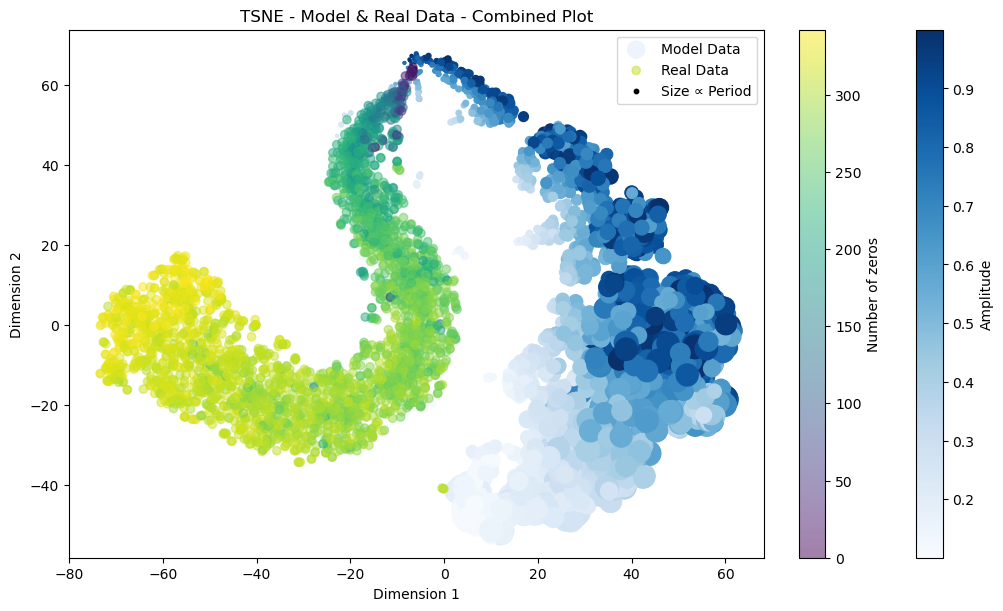

In [157]:
create_combined_plot(all_data_reduced_pca, len(model_data), combined_data, n_zeros_real, "Weekly Reports/Week 7/results/synthetic vs real data/PCA - Real vs. Model Data.png", "PCA")
create_combined_plot(all_data_reduced_tsne, len(model_data), combined_data, n_zeros_real, "Weekly Reports/Week 7/results/synthetic vs real data/TSNE - Real vs. Model Data.png", "TSNE")
create_combined_plot(all_data_reuduced_autoencoder, len(model_data), combined_data, n_zeros_real, "Weekly Reports/Week 7/results/synthetic vs real data/Autoencoder - Real vs. Model Data.png", "Autoencoder")

Analysing single column for synthetic data

In [32]:
# Load the model data
model_data, model_file_names = load_data_samples(model_data_dir, 'I', log_transform=False)
# Load the real data
real_data, real_file_names = load_data_samples(data_dir, 'I', log_transform=False)

Number of data samples: 2921
The shape of the data: (2921, 9, 40)
Number of data samples: 2880
The shape of the data: (2880, 9, 40)


In [ ]:
for i in range (real_data.shape[1]):
  column_real = real_data[:, i, :]
  n_zeros_real = count_zeros(column_real, 0)
  column_real_reduced_tsne = reduce_dimensions(column_real, method='t-SNE', init='pca')

  plot_reduced_data(column_real_reduced_tsne[:, 0], column_real_reduced_tsne[:, 1], method="t-SNE - Column " + str(i) + " - Real", color=n_zeros_real, color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/Single column t-SNE/real_column_" + str(i) + ".png")

for i in range (model_data.shape[1]):
  column_model = model_data[:, i, :]
  n_zeros_model = count_zeros(column_model, 0)
  column_model_reduced_tsne = reduce_dimensions(column_model, method='t-SNE', init='pca')

  plot_reduced_data(column_model_reduced_tsne[:, 0], column_model_reduced_tsne[:, 1], method="t-SNE - Column " + str(i) + " - Model", color=n_zeros_model, color_label="Number of zeros", save_path="Weekly Reports/Week 6/Synth Data Comparison/Single column t-SNE/model_column_" + str(i) + ".png")


### Fitting Gaussian

A hypothesis has been proposed: Clusters observed when applying t-distributed stochastic neighbor embedding (t-SNE) to a single column may arise because the data is not evenly distributed. We will test this hypothesis by fitting the column's data to a Gaussian distribution and observing the effect on the tsne clustering.

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from scipy.stats import norm

# Load the data
data_samples, file_names = load_data_samples(data_dir, 'I', flatten=False, log_transform=False)


# Define a function to fit a Gaussian distribution to a single data sample
def fit_gaussian(data_sample):
    # Calculate the mean and standard deviation of the data sample
    mean = np.mean(data_sample)
    std = np.std(data_sample)

    # Create a Gaussian distribution object with the calculated mean and standard deviation
    dist = norm(loc=mean, scale=std)

    # The probability density function (pdf) of a Gaussian distribution specifies the probability 
    # of a random variable taking on a given value, based on the distribution's parameters (mean, sd).
    # That means data_sample_norm represent new values for the data sample.
    # These values represent the probabilities of the random variable taking on the corresponding values in data_sample, according to the Gaussian distribution.
    data_sample_norm = dist.pdf(data_sample)

    return data_sample_norm

for i in range (data_samples.shape[1]):
    # Extract a single column of data
    column = data_samples[:, i, :] 
    n_zeros = count_zeros(column, 0)

    # Apply the function to each data sample in the column array
    gaussian_fits = np.apply_along_axis(fit_gaussian, axis=1, arr=column)

    # Normalize the Gaussian fits to ensure that they add up to 1 for each row
    normalized_gaussian_fits = gaussian_fits / np.sum(gaussian_fits, axis=1, keepdims=True)

    # Check that the sum of the normalized Gaussian fits is equal to 1 for each row
    print(np.sum(normalized_gaussian_fits, axis=1))

    reduced_data_tsne = reduce_dimensions(normalized_gaussian_fits, method='t-SNE', init='pca')
    plot_reduced_data(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], method="t-SNE - Gaussian - Column " + str(i), save_path="Weekly Reports/Week 7/results/Gaussian Fit/column_" + str(i) + "_tsne.png", color=n_zeros, color_label="Number of zeros")

In [119]:
from scipy.stats import norm

# Load the data
data_samples, file_names = load_data_samples(data_dir, 'I', flatten=True, log_transform=False)
no_zeros = count_zeros(data_samples, 0)

# Calculate the probability density function (pdf) for the flattened data
data_norm = fit_gaussian(data_samples)

normalized_data_norm = data_norm / np.sum(data_norm, axis=1, keepdims=True)

# Check that the sum of the normalized Gaussian fits is equal to 1 for each row
print(np.sum(normalized_data_norm, axis=1))

print(normalized_data_norm.shape)

reduced_data_tsne = reduce_dimensions(normalized_data_norm, method='t-SNE', init='pca')
plot_reduced_data(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], method="t-SNE - Gaussian - Column " + str(i), save_path="Weekly Reports/Week 7/results/Gaussian Fit/tsne.png", color=no_zeros, color_label="Number of zeros")
reduced_data_pca = reduce_dimensions(normalized_data_norm, method='PCA')
plot_reduced_data(reduced_data_pca[:, 0], reduced_data_pca[:, 1], method="PCA - Gaussian - Column " + str(i), save_path="Weekly Reports/Week 7/results/Gaussian Fit/pca.png", color=no_zeros, color_label="Number of zeros")
reduced_data_autoencoder = reduce_dimensions(normalized_data_norm, method='autoencoder')
plot_reduced_data(reduced_data_autoencoder[:, 0], reduced_data_autoencoder[:, 1], method="Autoencoder - Gaussian - Column " + str(i), save_path="Weekly Reports/Week 7/results/Gaussian Fit/autoencoder.png", color=no_zeros, color_label="Number of zeros")

Number of data samples: 2880
The shape of the data: (2880, 360)
[1. 1. 1. ... 1. 1. 1.]
(2880, 360)
Shape of the data before autoencoder: (2880, 360)
Shape of the data after autoencoder: (2880, 2)


Replacing each column of values with the standard deviation of that column is a simple transformation that could potentially provide some insight. 

In [98]:
# Load the data
data_samples, file_names = load_data_samples(data_dir, 'I', flatten=False, log_transform=False)

data_samples_sd = np.zeros((data_samples.shape[0], data_samples.shape[1]))

for i in range(data_samples.shape[0]):  # For each data sample
    for j in range(data_samples.shape[1]): # For each column
        column = data_samples[i,j,:] 
        std = np.std(column)
        data_samples_sd[i,j] = std

data_samples_sd_reduced_pca = reduce_dimensions(data_samples_sd, method='PCA')
plot_reduced_data(data_samples_sd_reduced_pca[:, 0], data_samples_sd_reduced_pca[:, 1], method="PCA - Standard Deviation Transformation", save_path="Weekly Reports/Week 7/results/Standard Deviation/pca.png", color=no_zeros, color_label="Number of zeros")
data_samples_sd_reduced_tsne = reduce_dimensions(data_samples_sd, method='t-SNE')
plot_reduced_data(data_samples_sd_reduced_tsne[:, 0], data_samples_sd_reduced_tsne[:, 1], method="t-SNE - Standard Deviation Transformation", save_path="Weekly Reports/Week 7/results/Standard Deviation/tsne.png", color=no_zeros, color_label="Number of zeros")
data_samples_sd_reduced_autoencoder = reduce_dimensions(data_samples_sd, method='autoencoder')
plot_reduced_data(data_samples_sd_reduced_autoencoder[:, 0], data_samples_sd_reduced_autoencoder[:, 1], method="Autoencoder - Standard Deviation Transformation", save_path="Weekly Reports/Week 7/results/Standard Deviation/autoencoder.png", color=no_zeros, color_label="Number of zeros")

Number of data samples: 2880
The shape of the data: (2880, 9, 40)
Shape of the data before autoencoder: (2880, 9)
Shape of the data after autoencoder: (2880, 2)
